## Caso Práctico: Prevención de Infartos

In [57]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style='darkgrid')
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

from sklearn import tree
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont

In [58]:
pwd

'/content'



```
# Tiene formato de código
```

### EXPLORACIÓN DE DATA: 5 INSIGHTS




In [59]:
df=pd.read_csv('2_DS_train_enf_corazon.csv',sep = ";",encoding = 'latin1')
df.shape

(43400, 12)

In [60]:
df.head()

,ID,Genero,Edad,Flag_hipertension,Flag_problem_cardiaco,Estados_civil,Tipo_trabajo,Zona_residencia,Promedio_nivel_glucosa,IMC,Flag_fumador,Ataque_cardiaco
0,30669,Hombre,3.0,0,0,No,cuidar_ninos,Rural,95.12,18.0,NaN,0
1,30468,Hombre,58.0,1,0,Si,Empresa_privada,Urbano,87.96,39.2,Nunca_fuma,0
2,16523,Mujer,8.0,0,0,No,Empresa_privada,Urbano,110.89,17.6,NaN,0
3,56543,Mujer,70.0,0,0,Si,Empresa_privada,Rural,69.04,35.9,antes_fumaba,0
4,46136,Hombre,14.0,0,0,No,Nunca_trabajo,Rural,161.28,19.1,NaN,0


## *ANALISIS DE VALORES NULOS:*


In [61]:
df.isna().sum()

ID                            0
Genero                        0
Edad                          0
Flag_hipertension             0
Flag_problem_cardiaco         0
Estados_civil                 0
Tipo_trabajo                  0
Zona_residencia               0
Promedio_nivel_glucosa        0
IMC                        1462
Flag_fumador              13292
Ataque_cardiaco               0
dtype: int64

Se observa que las variables IMC y Flag_fumadores poseen valores nulos.

Usaremos la siguiente libreria de graficos para encontrar alguna relacion de estos valores nulos:


In [62]:
#!pip install missingno

<Axes: >

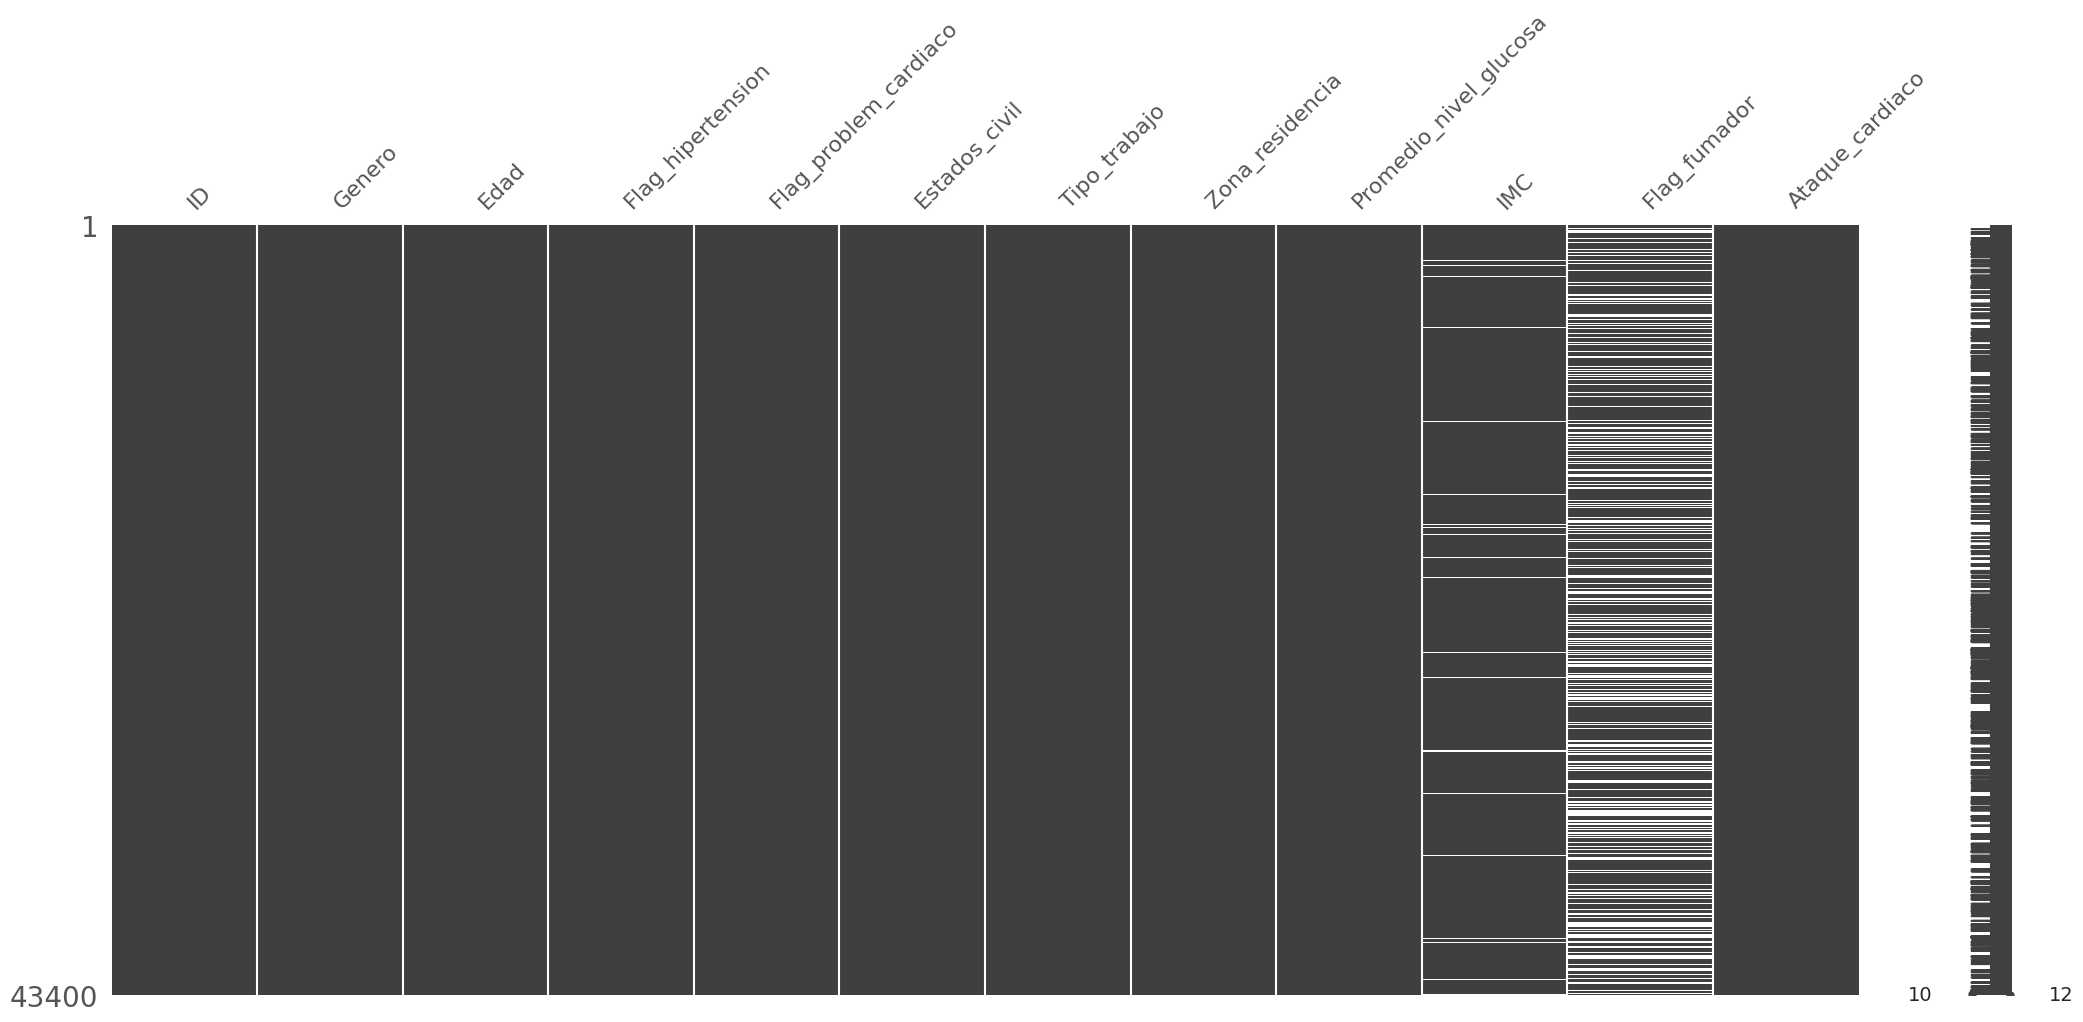

In [63]:
import missingno as msno
msno.matrix(df)

Se observa una gran cantidad de valores nulos en la variable Flag_fumador= 30.6%


## Variable objetivo (Target)

In [64]:
df.groupby('Ataque_cardiaco').size()

Ataque_cardiaco
0    42617
1      783
dtype: int64

<Axes: xlabel='Ataque_cardiaco', ylabel='count'>

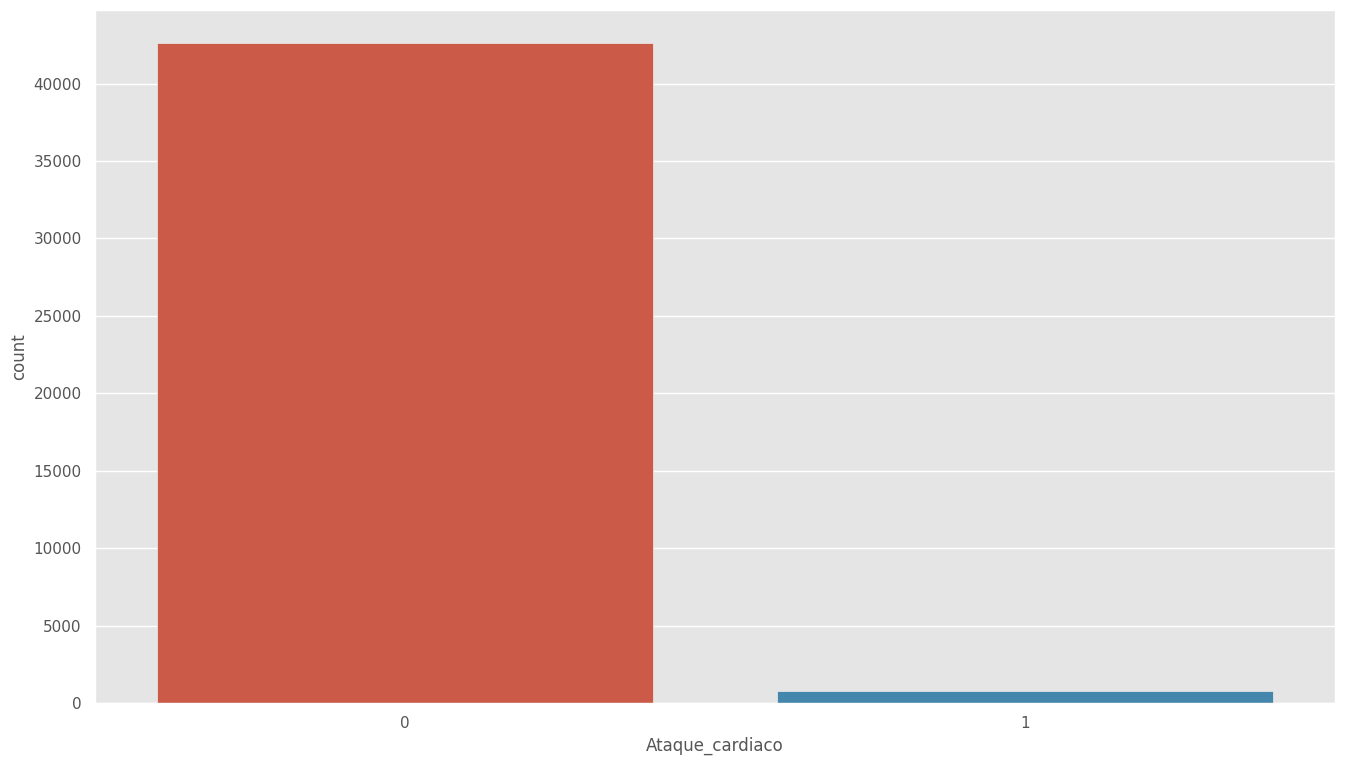

In [65]:
#sns.factorplot('Ataque_cardiaco',data=df,kind="count")
sns.countplot(x='Ataque_cardiaco',data=df)

Aproximadamente el 1.8% de las personas ha sufrido un infarto. DATA DESBALANCEADA

## Variables Cuantitativas

In [66]:
df.describe()

,ID,Edad,Flag_hipertension,Flag_problem_cardiaco,Promedio_nivel_glucosa,IMC,Ataque_cardiaco
count,43400.000000,43400.000000,43400.000000,43400.000000,43400.000000,41938.000000,43400.000000
mean,36326.142350,42.217894,0.093571,0.047512,104.482750,28.605038,0.018041
std,21072.134879,22.519649,0.291235,0.212733,43.111751,7.770020,0.133103
min,1.000000,0.080000,0.000000,0.000000,55.000000,10.100000,0.000000
25%,18038.500000,24.000000,0.000000,0.000000,77.540000,23.200000,0.000000
50%,36351.500000,44.000000,0.000000,0.000000,91.580000,27.700000,0.000000
75%,54514.250000,60.000000,0.000000,0.000000,112.070000,32.900000,0.000000
max,72943.000000,82.000000,1.000000,1.000000,291.050000,97.600000,1.000000


Analizando las variables numericas: Edad, Promedio_nivel_glucosa, IMC
No se evidencian outliners, ya que la media> std

AHORA GRAFICAREMOS LOS HISTOGRAMAS DE CADA VARIABLE:


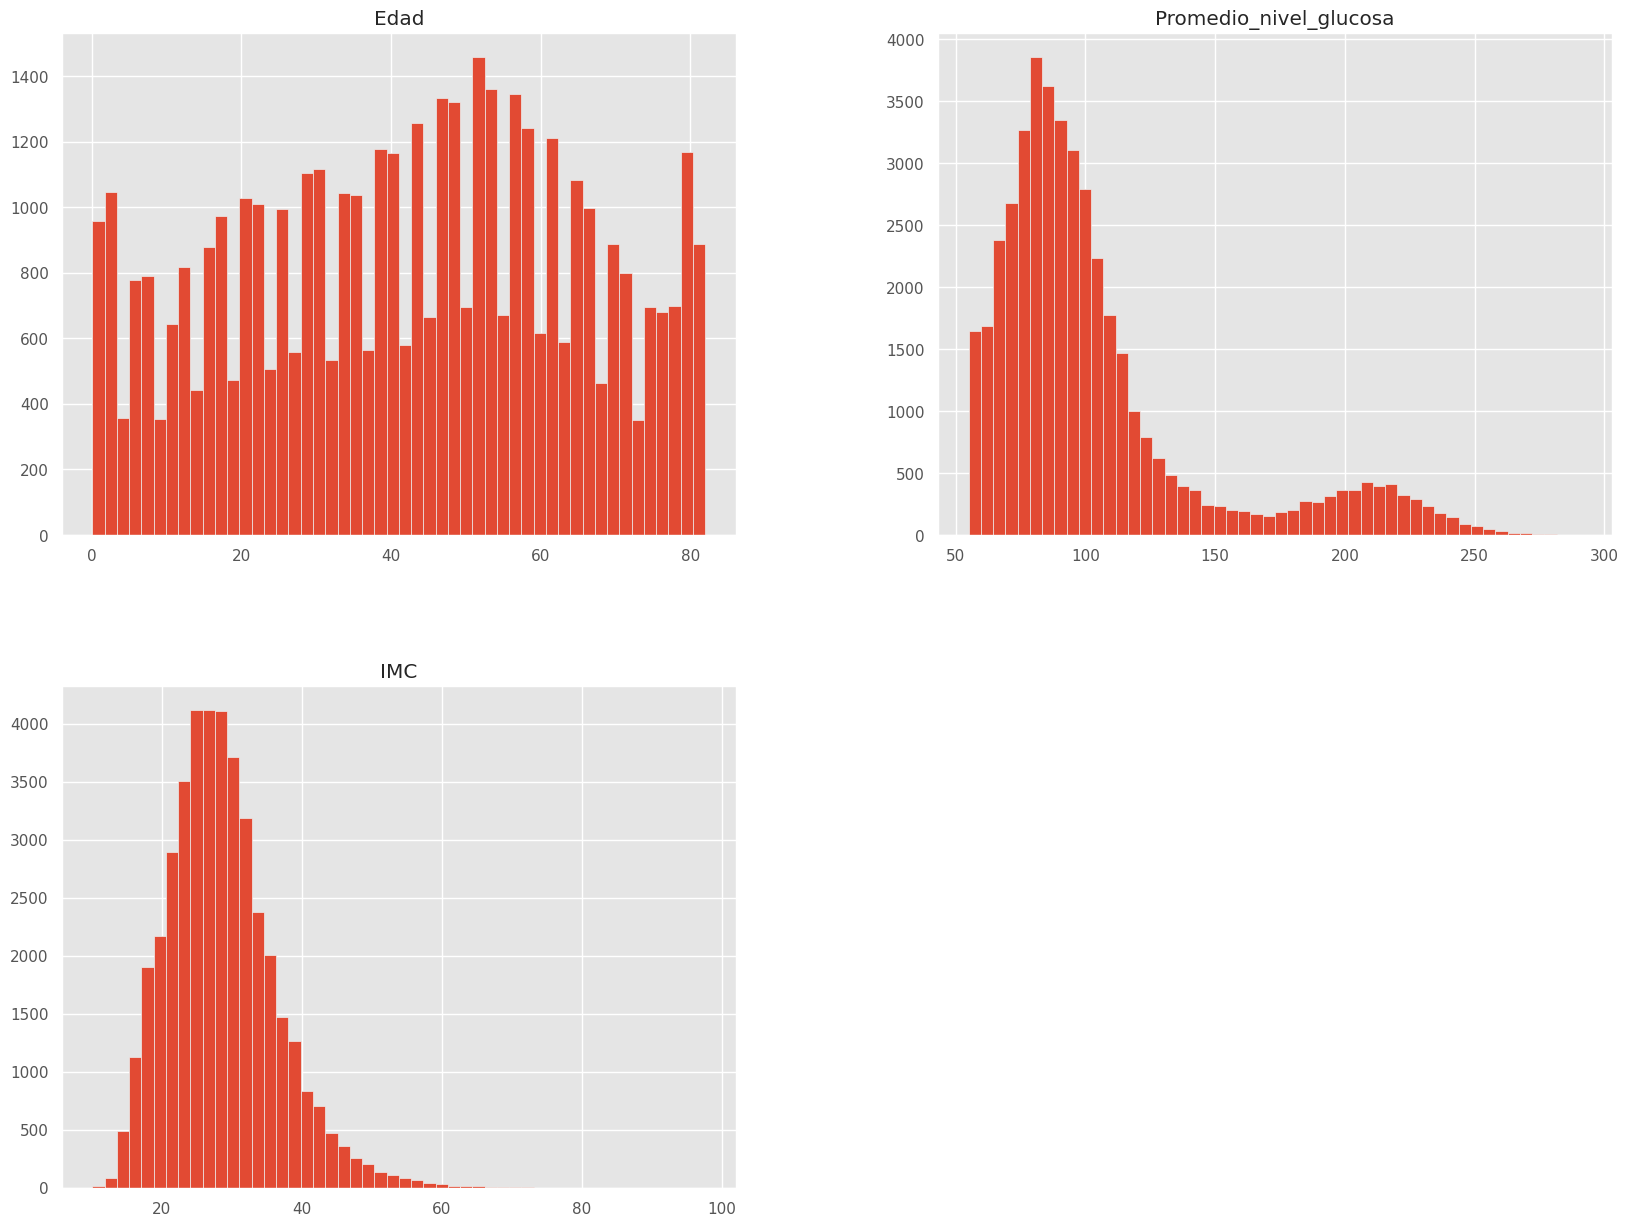

In [67]:
Var=['Edad','Promedio_nivel_glucosa','IMC']
df[Var].hist(bins=50 ,figsize=(20,15))
plt.show()


Se evidencia una tendencia para las variables: IMC y Nivel de glucos. Posiblemente sean variables criticas.


Ahora cruzamos las variables numéricas entre ellas y adiconalmente agregamos el Target para conocer la distribución y comenzar a generar hipótesis de variables que discriminan mejor a ambos grupos (Ataque Cardiaco).

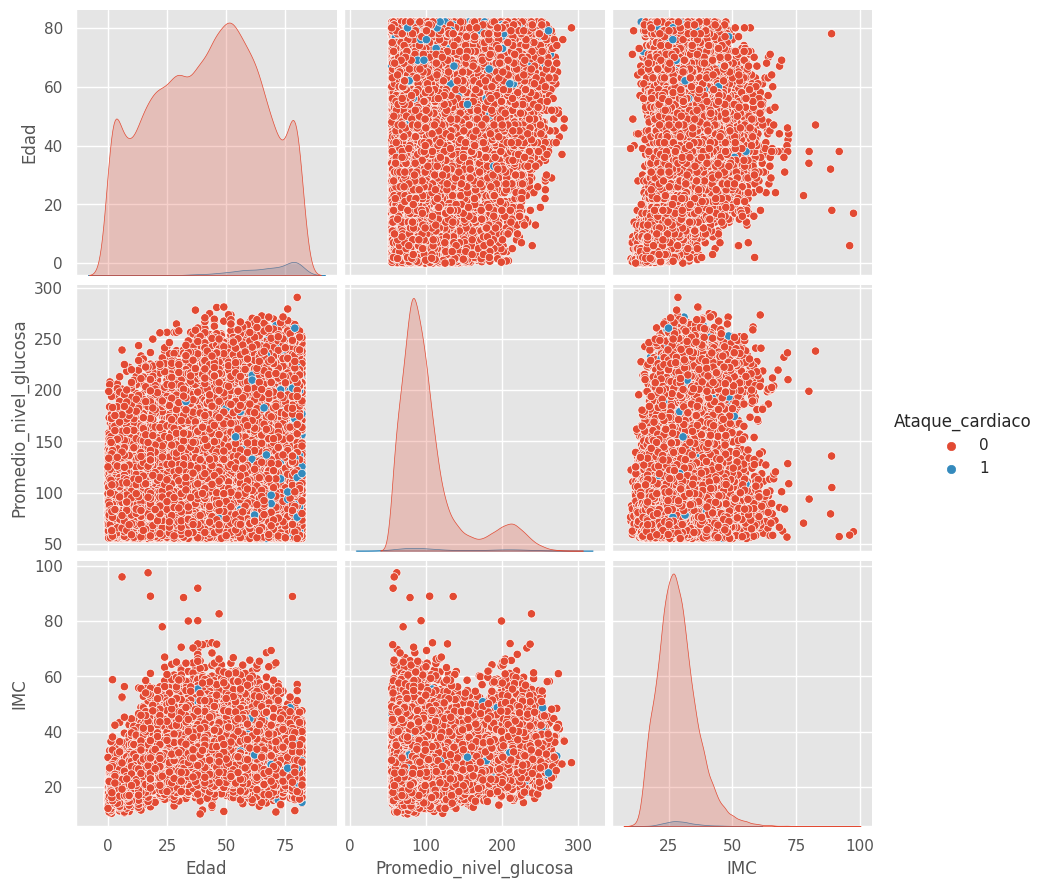

In [68]:
Variables = ['Edad','Promedio_nivel_glucosa','IMC','Ataque_cardiaco']
sns.pairplot(df[Variables], height=3, diag_kind = 'kde', hue='Ataque_cardiaco')

Del grafico se deduce que la edad es un valor critico debido a que la mayoria de '1' o puntos azules se encuentran en las zonas de mayor edad.

CORRELACIONES DE VARIBLES:


<Axes: >

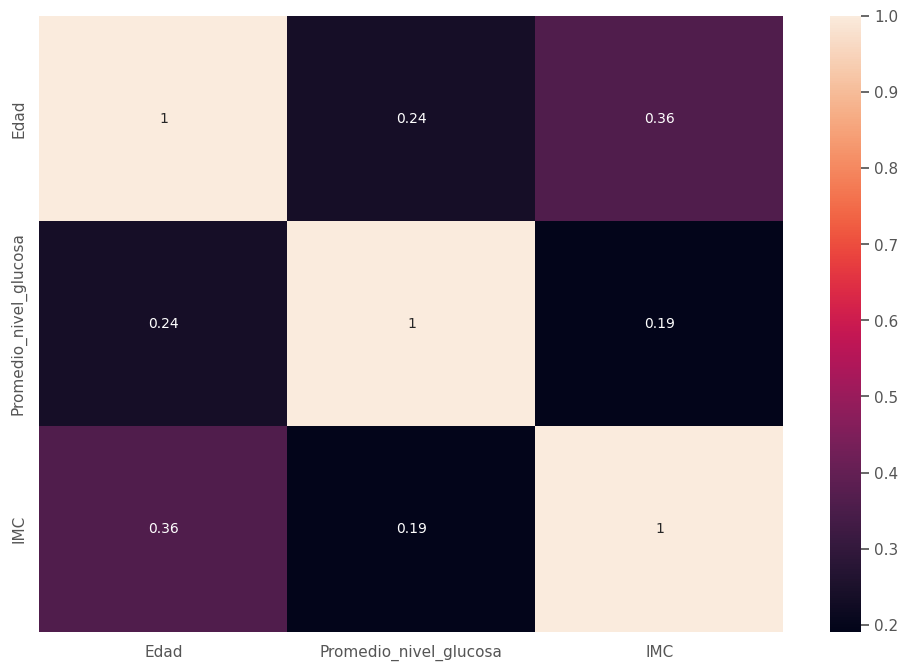

In [69]:
corr = df[['Edad','Promedio_nivel_glucosa','IMC']].corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True)

No se observan correlaciones considerables.

## Variables Cualitativas

Obtendremos las variables cualitativas para conocer su distribución y su relación con la variable "Target".

In [70]:
categorias = df.select_dtypes(include=['object'])
categorias.dtypes

Genero             object
Estados_civil      object
Tipo_trabajo       object
Zona_residencia    object
Flag_fumador       object
dtype: object

### Genero


<bound method Series.sort_index of Mujer     0.591359
Hombre    0.408387
Other     0.000253
Name: Genero, dtype: float64>

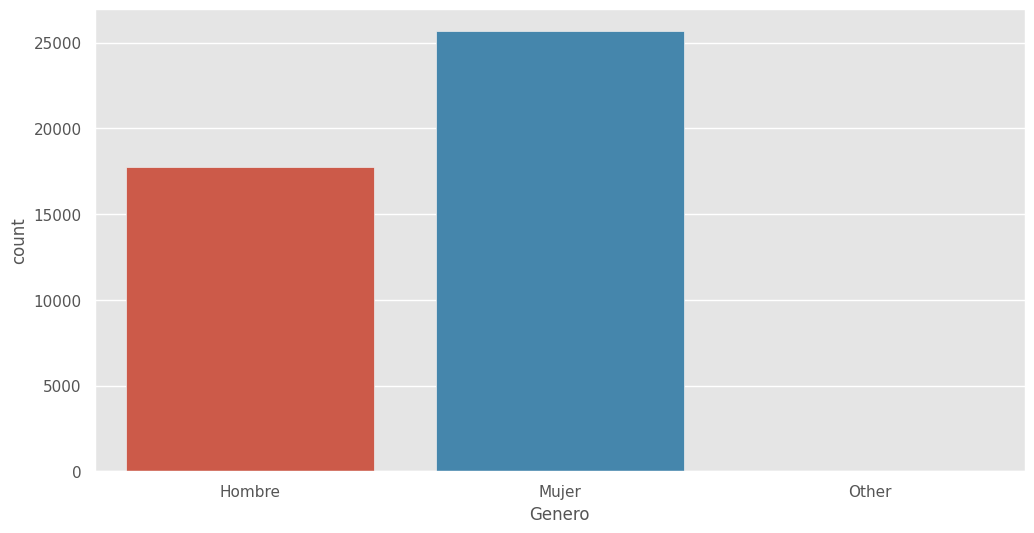

In [71]:
plt.figure(figsize=(12,6))
sns.countplot(data = categorias, x = "Genero")
df['Genero'].value_counts(1).sort_index

Se tiene:
 59% Mujeres
  41% Hombres

Ahora correlacionamos esta variable con el TARGET:

Ataque_cardiaco               
                 count  sum      mean
Genero                               
Hombre           17724  352  0.019860
Mujer            25665  431  0.016793
Other               11    0  0.000000

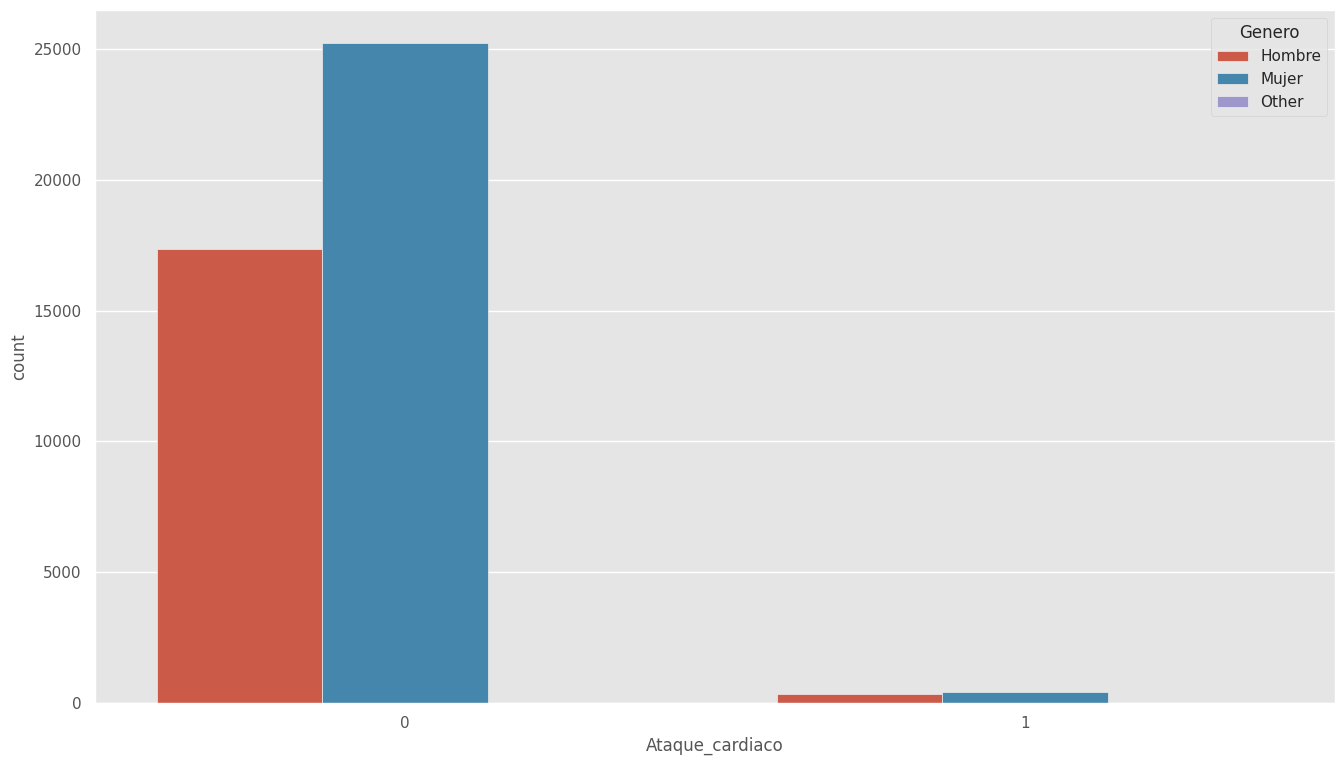

In [72]:
#ns.factorplot('Ataque_cardiaco',data=df,hue='Genero',kind="count")
sns.countplot(x='Ataque_cardiaco',data=df,hue='Genero')
df[['Genero', 'Ataque_cardiaco']].groupby(['Genero'], as_index=False).agg(['count','sum','mean'])

No Existe algun impacto o diferencia en el target.

### Estados_civil


<bound method Series.sort_index of Si    27938
No    15462
Name: Estados_civil, dtype: int64>

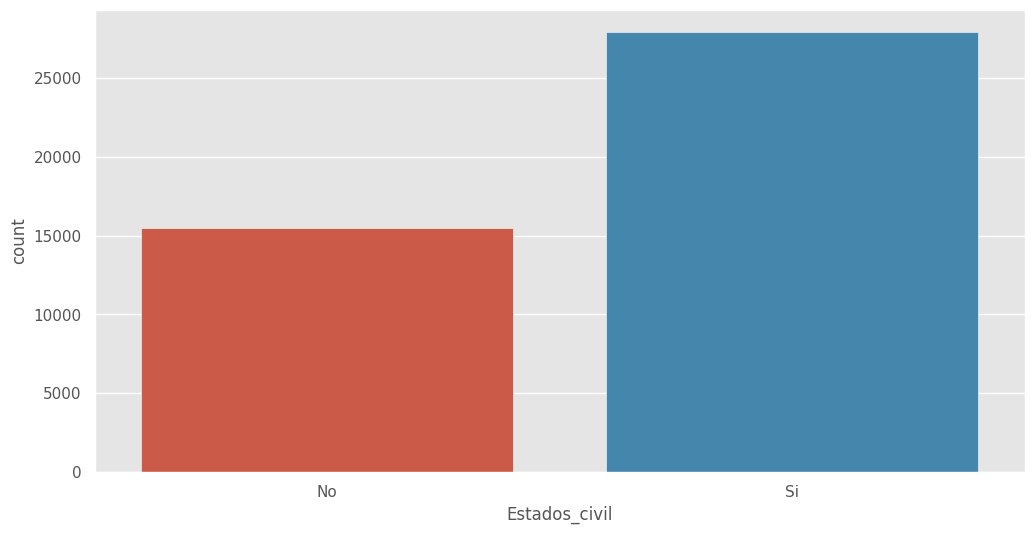

In [73]:
plt.figure(figsize=(12,6))
sns.countplot(data = categorias, x = "Estados_civil")
df['Estados_civil'].value_counts(0).sort_index

Ataque_cardiaco               
                        count  sum      mean
Estados_civil                               
No                      15462   80  0.005174
Si                      27938  703  0.025163

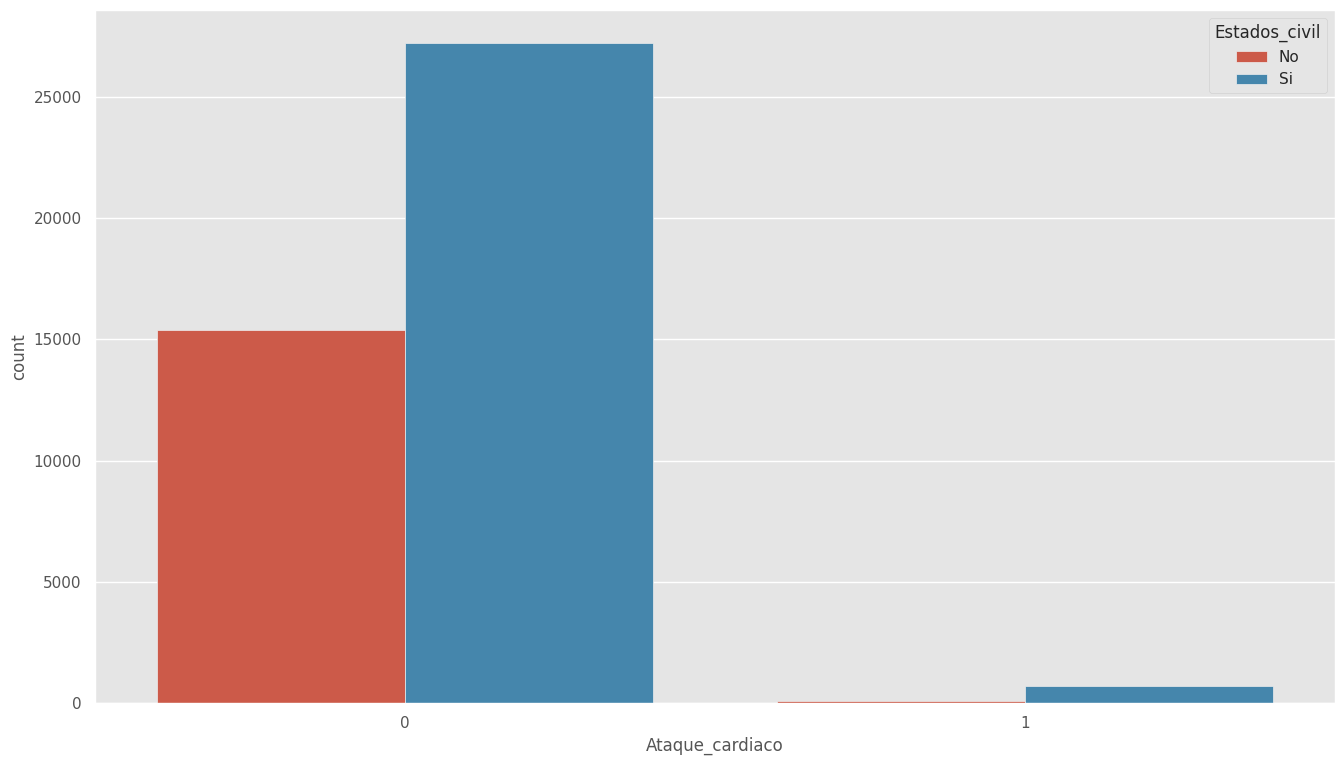

In [74]:
#sns.factorplot('Ataque_cardiaco',data=df,hue='Estados_civil',kind="count")
sns.countplot(x='Ataque_cardiaco',data=df,hue='Estados_civil')
df[['Estados_civil', 'Ataque_cardiaco']].groupby(['Estados_civil'], as_index=False).agg(['count','sum','mean'])

Se ve un mayor porcentaje para los casados, pero que por el gran desbalance de DATA no se logra apreciar mejor.

### Tipo_trabajo

<bound method Series.sort_index of Empresa_privada    24834
Emprendedor         6793
cuidar_ninos        6156
En_gobierno         5440
Nunca_trabajo        177
Name: Tipo_trabajo, dtype: int64>

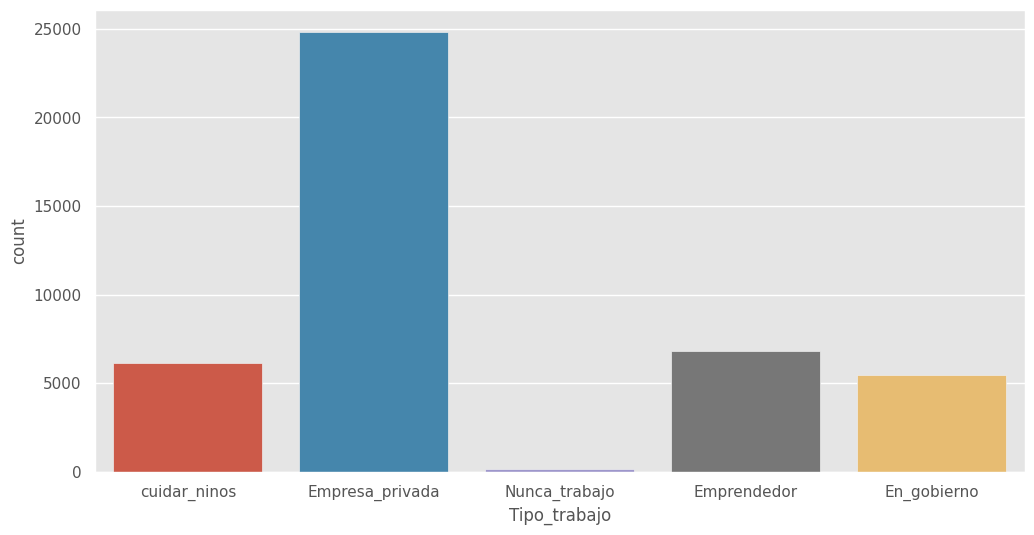

In [75]:
plt.figure(figsize=(12,6))
sns.countplot(data = categorias, x = "Tipo_trabajo")
df['Tipo_trabajo'].value_counts(0).sort_index

Ataque_cardiaco               
                          count  sum      mean
Tipo_trabajo                                  
Emprendedor                6793  251  0.036950
Empresa_privada           24834  441  0.017758
En_gobierno                5440   89  0.016360
Nunca_trabajo               177    0  0.000000
cuidar_ninos               6156    2  0.000325

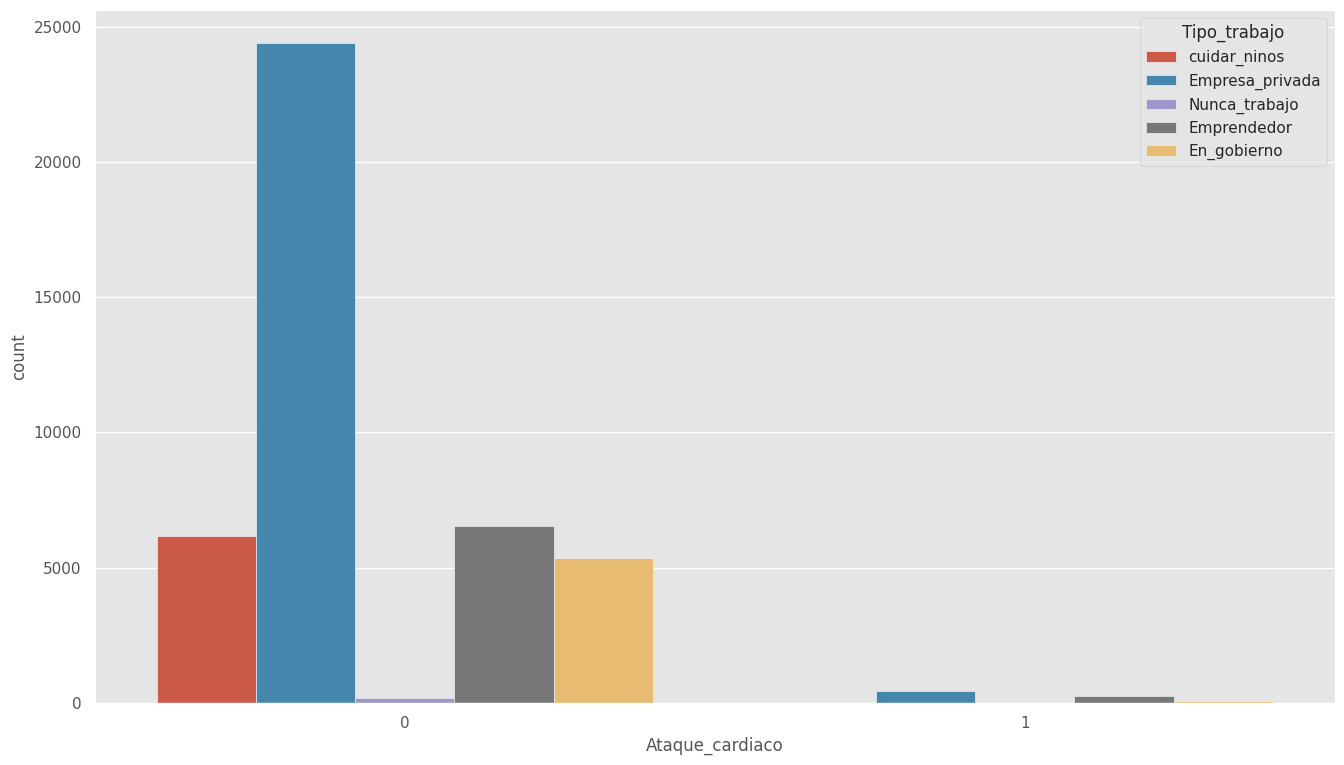

In [76]:
#sns.factorplot('Ataque_cardiaco',data=df,hue='Tipo_trabajo',kind="count")
sns.countplot(x='Ataque_cardiaco',data=df,hue='Tipo_trabajo')
df[['Tipo_trabajo', 'Ataque_cardiaco']].groupby(['Tipo_trabajo'], as_index=False).agg(['count','sum','mean'])

Aca si se nota una tendencia a ciertas subvariables como el ser emprendedor tiene un mayor riesgo de un ataque cardiaco.

### Zona_residencia

<bound method Series.sort_index of Urbano    21756
Rural     21644
Name: Zona_residencia, dtype: int64>

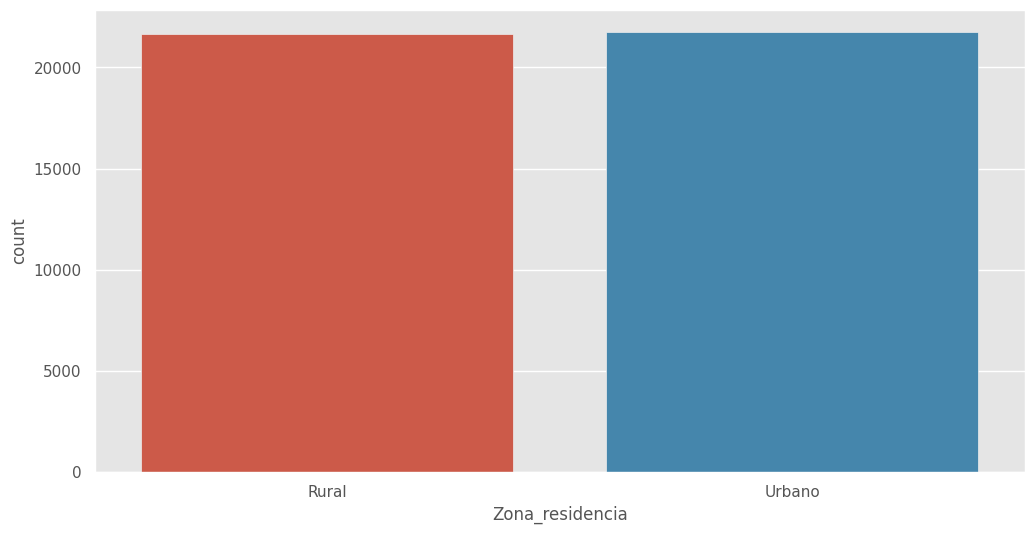

In [77]:
plt.figure(figsize=(12,6))
sns.countplot(data = categorias, x = "Zona_residencia")
df['Zona_residencia'].value_counts(0).sort_index

Ataque_cardiaco               
                          count  sum      mean
Zona_residencia                               
Rural                     21644  384  0.017742
Urbano                    21756  399  0.018340

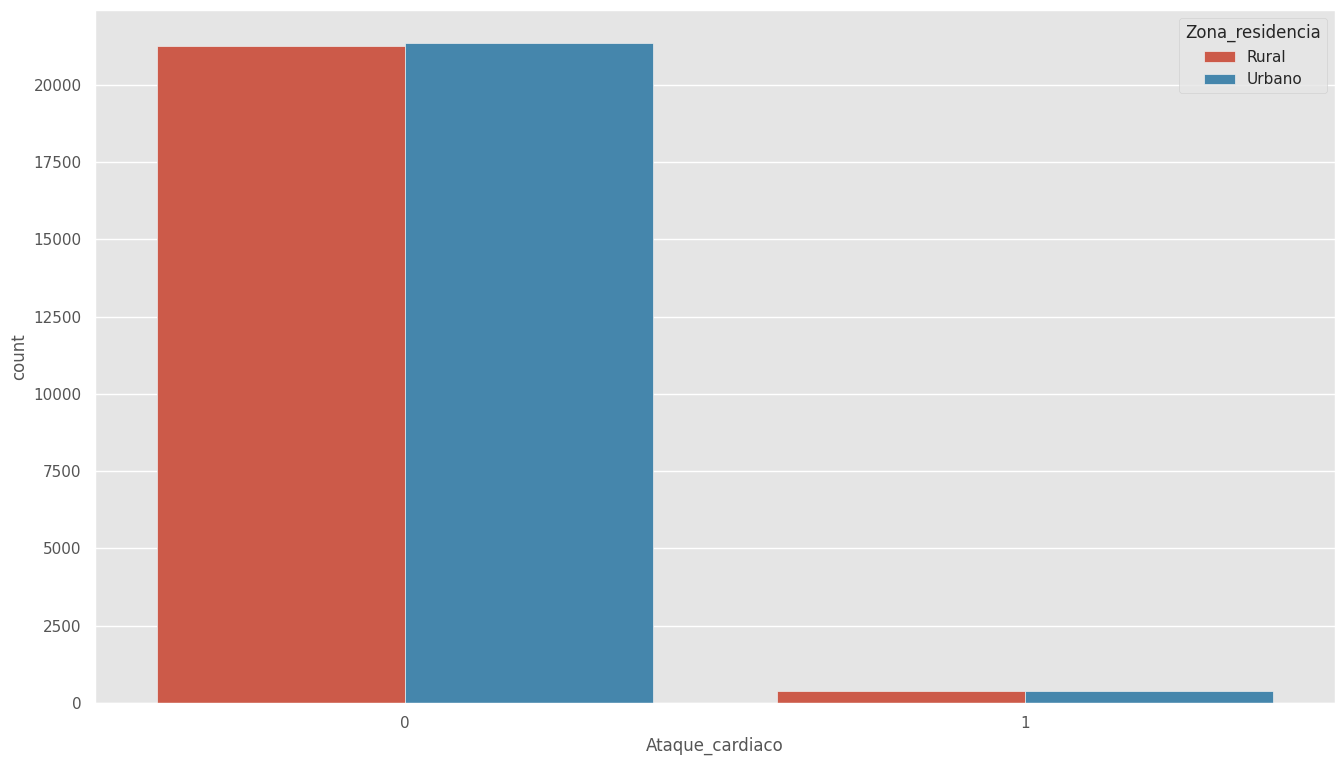

In [78]:
#sns.factorplot('Ataque_cardiaco',data=df,hue='Zona_residencia',kind="count")
sns.countplot(x='Ataque_cardiaco',data=df,hue='Zona_residencia')
df[['Zona_residencia', 'Ataque_cardiaco']].groupby(['Zona_residencia'], as_index=False).agg(['count','sum','mean'])

No existe ninguna tendencia o diferencia para este tipo de variables

### Flag_fumador

<bound method Series.sort_index of Nunca_fuma      16053
antes_fumaba     7493
fumador          6562
Name: Flag_fumador, dtype: int64>

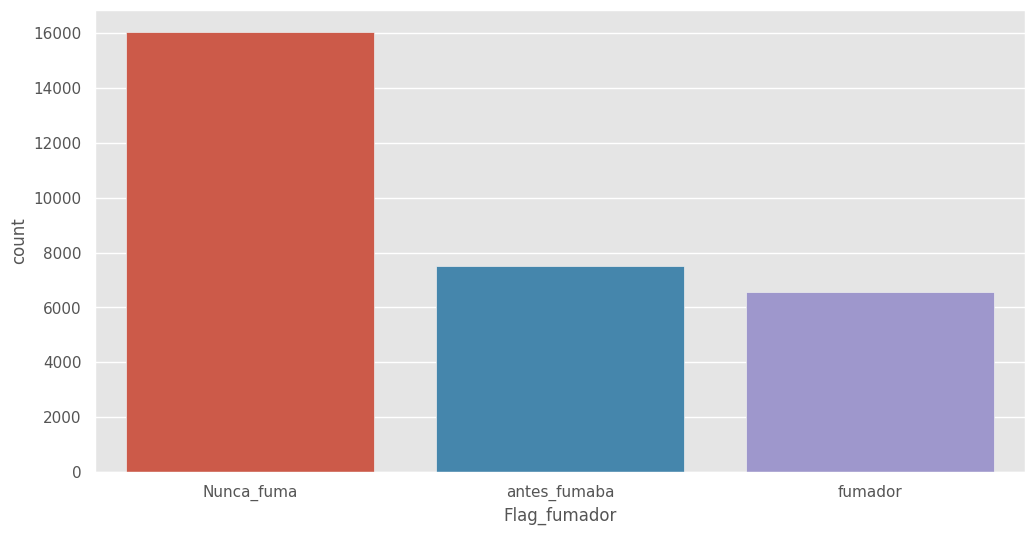

In [79]:
plt.figure(figsize=(12,6))
sns.countplot(data = categorias, x = "Flag_fumador")
df['Flag_fumador'].value_counts(0).sort_index

Ataque_cardiaco               
                       count  sum      mean
Flag_fumador                               
Nunca_fuma             16053  284  0.017691
antes_fumaba            7493  221  0.029494
fumador                 6562  133  0.020268

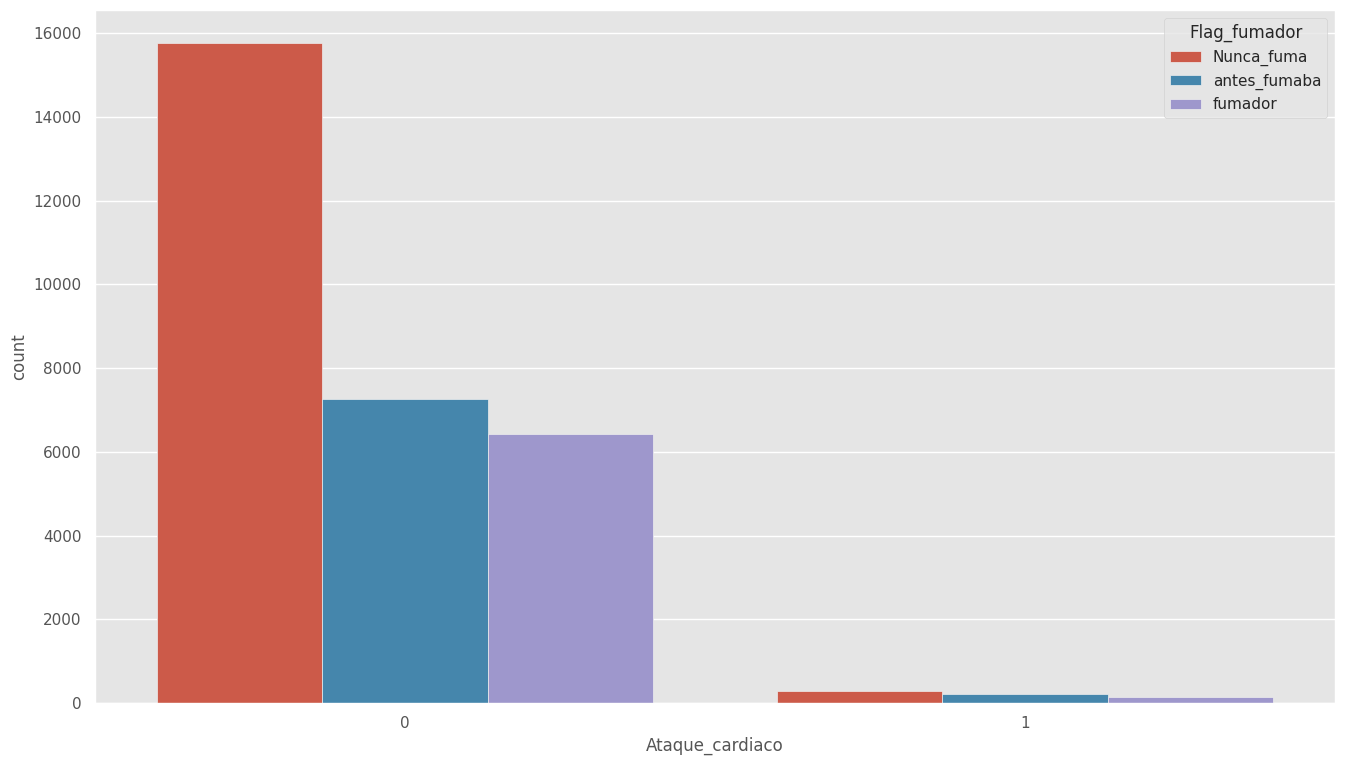

In [80]:
#sns.factorplot('Ataque_cardiaco',data=df,hue='Flag_fumador',kind="count")
sns.countplot(x='Ataque_cardiaco',data=df,hue='Flag_fumador')
df[['Flag_fumador', 'Ataque_cardiaco']].groupby(['Flag_fumador'], as_index=False).agg(['count','sum','mean'])

Aca debemos de considerar que se tiene un numero considerable de nulos. Lo que cuestiona la fidelidad de esta variable. No se debe tomar esta variable.


##SE TIENE POR AHORA LAS SIGUIENTES VARIABLES:

-CUANTITATIVAS:

Edad, Promedio_nivel_glucosa, IMC

-CUALITATIVAS:

Estado_civil, Tipo_trabajo, Flag_fumador




# TRATAMIENTO: Tecnica de imputacion y transformacion de variables


## Imputación de datos

Analizamos las variables cuantitativas en busca de outliers:


In [81]:
df.describe()

,ID,Edad,Flag_hipertension,Flag_problem_cardiaco,Promedio_nivel_glucosa,IMC,Ataque_cardiaco
count,43400.000000,43400.000000,43400.000000,43400.000000,43400.000000,41938.000000,43400.000000
mean,36326.142350,42.217894,0.093571,0.047512,104.482750,28.605038,0.018041
std,21072.134879,22.519649,0.291235,0.212733,43.111751,7.770020,0.133103
min,1.000000,0.080000,0.000000,0.000000,55.000000,10.100000,0.000000
25%,18038.500000,24.000000,0.000000,0.000000,77.540000,23.200000,0.000000
50%,36351.500000,44.000000,0.000000,0.000000,91.580000,27.700000,0.000000
75%,54514.250000,60.000000,0.000000,0.000000,112.070000,32.900000,0.000000
max,72943.000000,82.000000,1.000000,1.000000,291.050000,97.600000,1.000000


Como se observó previamente no existe indicios de valores atípicos
Pero analicemos la edad: se tiene valores decimales = 0 - 1.8




<Axes: xlabel='Edad', ylabel='count'>

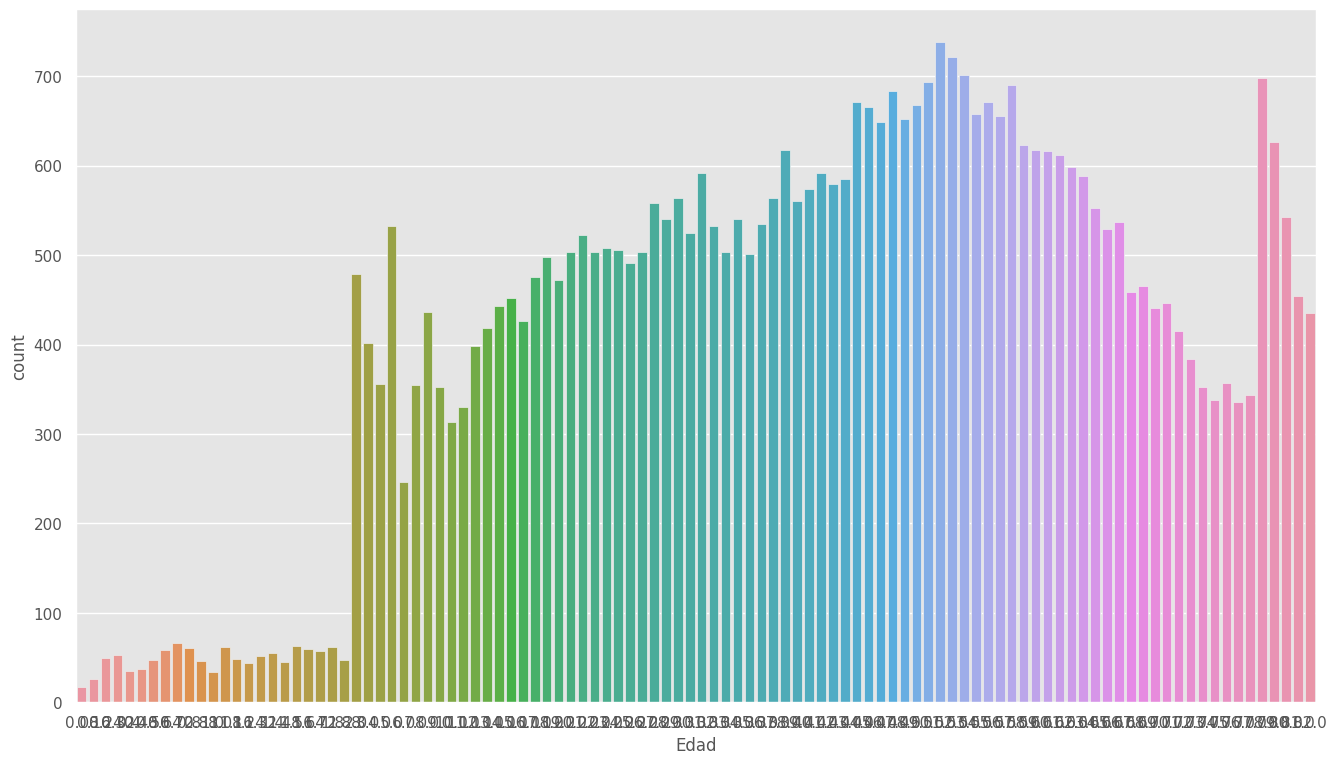

In [82]:
#sns.factorplot('Edad',data=df,kind="count", aspect=8)
sns.countplot(data = df, x = "Edad")

<Axes: xlabel='Genero', ylabel='Edad'>

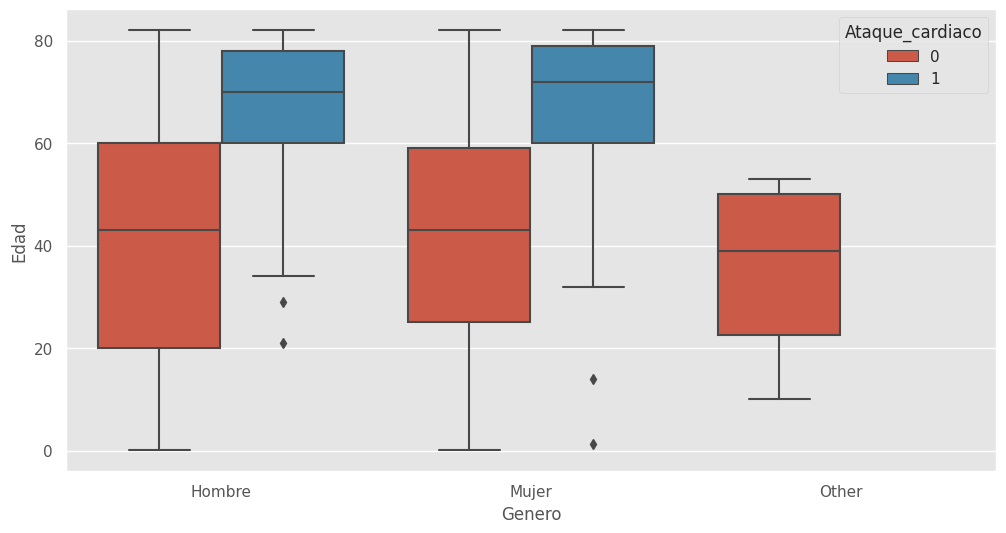

In [83]:
plt.figure(figsize=(12,6))
sns.boxplot(x="Genero",y="Edad", hue="Ataque_cardiaco", data=df)

Utilizamos la tecnica de imputación, eliminando los valores atipicos de las edades:



In [84]:
age_avg = df['Edad'].mean()
age_std = df['Edad'].std()
age_null_count = df['Edad'].isnull().sum()
age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)

conValoresNulos = np.isnan(df['Edad'])

df.loc[np.isnan(df['Edad']), 'Edad'] = age_null_random_list
df['Edad'] = df['Edad'].astype(int)

print("Edad Promedio: " + str(age_avg))
print("Desvió Std Edad: " + str(age_std))
print("Intervalo para asignar edad aleatoria: " + str(int(age_avg - age_std)) + " a " + str(int(age_avg + age_std)))

Edad Promedio: 42.21789400921659
Desvió Std Edad: 22.51964868050339
Intervalo para asignar edad aleatoria: 19 a 64


In [85]:
def edad_fix(edad):
    if edad==0:
        return None
    return edad

df['Edad']=df.apply(lambda x: edad_fix(x['Edad']), axis=1);


In [ ]:
df.head(20)

,ID,Genero,Edad,Flag_hipertension,Flag_problem_cardiaco,Estados_civil,Tipo_trabajo,Zona_residencia,Promedio_nivel_glucosa,IMC,Flag_fumador,Ataque_cardiaco
0,30669,Hombre,3.0,0,0,No,cuidar_ninos,Rural,95.12,18.0,NaN,0
1,30468,Hombre,58.0,1,0,Si,Empresa_privada,Urbano,87.96,39.2,Nunca_fuma,0
2,16523,Mujer,8.0,0,0,No,Empresa_privada,Urbano,110.89,17.6,NaN,0
3,56543,Mujer,70.0,0,0,Si,Empresa_privada,Rural,69.04,35.9,antes_fumaba,0
4,46136,Hombre,14.0,0,0,No,Nunca_trabajo,Rural,161.28,19.1,NaN,0
5,32257,Mujer,47.0,0,0,Si,Empresa_privada,Urbano,210.95,50.1,NaN,0
6,52800,Mujer,52.0,0,0,Si,Empresa_privada,Urbano,77.59,17.7,antes_fumaba,0
7,41413,Mujer,75.0,0,1,Si,Emprendedor,Rural,243.53,27.0,Nunca_fuma,0
8,15266,Mujer,32.0,0,0,Si,Empresa_privada,Rural,77.67,32.3,fumador,0
9,28674,Mujer,74.0,1,0,Si,Emprendedor,Urbano,205.84,54.6,Nunca_fuma,0


In [87]:
df.isna().sum()

ID                            0
Genero                        0
Edad                        496
Flag_hipertension             0
Flag_problem_cardiaco         0
Estados_civil                 0
Tipo_trabajo                  0
Zona_residencia               0
Promedio_nivel_glucosa        0
IMC                        1462
Flag_fumador              13292
Ataque_cardiaco               0
dtype: int64

In [88]:
df.describe()

,ID,Edad,Flag_hipertension,Flag_problem_cardiaco,Promedio_nivel_glucosa,IMC,Ataque_cardiaco
count,43400.000000,42904.000000,43400.000000,43400.000000,43400.000000,41938.000000,43400.000000
mean,36326.142350,42.693012,0.093571,0.047512,104.482750,28.605038,0.018041
std,21072.134879,22.208961,0.291235,0.212733,43.111751,7.770020,0.133103
min,1.000000,1.000000,0.000000,0.000000,55.000000,10.100000,0.000000
25%,18038.500000,25.000000,0.000000,0.000000,77.540000,23.200000,0.000000
50%,36351.500000,44.000000,0.000000,0.000000,91.580000,27.700000,0.000000
75%,54514.250000,60.000000,0.000000,0.000000,112.070000,32.900000,0.000000
max,72943.000000,82.000000,1.000000,1.000000,291.050000,97.600000,1.000000


## MAPPING DE VARIABLES CUALITATIVAS

In [89]:
df.head()

,ID,Genero,Edad,Flag_hipertension,Flag_problem_cardiaco,Estados_civil,Tipo_trabajo,Zona_residencia,Promedio_nivel_glucosa,IMC,Flag_fumador,Ataque_cardiaco
0,30669,Hombre,3.0,0,0,No,cuidar_ninos,Rural,95.12,18.0,NaN,0
1,30468,Hombre,58.0,1,0,Si,Empresa_privada,Urbano,87.96,39.2,Nunca_fuma,0
2,16523,Mujer,8.0,0,0,No,Empresa_privada,Urbano,110.89,17.6,NaN,0
3,56543,Mujer,70.0,0,0,Si,Empresa_privada,Rural,69.04,35.9,antes_fumaba,0
4,46136,Hombre,14.0,0,0,No,Nunca_trabajo,Rural,161.28,19.1,NaN,0


In [90]:
# Estados_civil Mapping
df['Estado_Encoded'] = df['Estados_civil'].map( {'Si': 1,
                                        'No': 0,
                                        '':0} ).astype(int)

In [91]:
# Tipo_trabajo Mapping
df['Tipo_trabajo_Encoded'] = df['Tipo_trabajo'].map( {'cuidar_ninos': 1, 'Empresa_privada': 3, 'Nunca_trabajo': 0, 'Emprendedor': 4, 'En_gobierno':2 } ).astype(int)

In [92]:
# Edad Mapping

df.loc[ df['Edad'] <= 16, 'Edad_Encoded'] 					       = 0
df.loc[(df['Edad'] > 16) & (df['Edad'] <= 33), 'Edad_Encoded'] = 1
df.loc[(df['Edad'] > 33) & (df['Edad'] <= 50), 'Edad_Encoded'] = 2
df.loc[(df['Edad'] > 50) & (df['Edad'] <= 67), 'Edad_Encoded'] = 3
df.loc[ df['Edad'] > 67, 'Edad_Encoded'] = 4

In [93]:
# Glucosa mapping

df.loc[(df['Promedio_nivel_glucosa'] >= 50) & (df['Promedio_nivel_glucosa'] <= 100), 'Glucosa_Encoded'] = 0
df.loc[(df['Promedio_nivel_glucosa'] > 100) & (df['Promedio_nivel_glucosa'] <= 150), 'Glucosa_Encoded'] = 1
df.loc[(df['Promedio_nivel_glucosa'] > 150) & (df['Promedio_nivel_glucosa'] <= 200), 'Glucosa_Encoded'] = 2
df.loc[(df['Promedio_nivel_glucosa'] > 200) & (df['Promedio_nivel_glucosa'] <= 250), 'Glucosa_Encoded'] = 3
df.loc[ df['Promedio_nivel_glucosa'] > 250, 'Glucosa_Encoded'] = 4

In [94]:
# IMC mapping

df.loc[df['IMC'] <= 10, 'IMC_Encoded'] = 0
df.loc[(df['IMC'] > 10) & (df['IMC'] <= 30), 'IMC_Encoded'] = 1
df.loc[(df['IMC'] > 30) & (df['IMC'] <= 40), 'IMC_Encoded'] = 2
df.loc[(df['IMC'] > 40) & (df['IMC'] <= 60), 'IMC_Encoded'] = 3
df.loc[ df['IMC'] > 60, 'IMC_Encoded'] = 4



In [95]:
df.head()

,ID,Genero,Edad,Flag_hipertension,Flag_problem_cardiaco,Estados_civil,Tipo_trabajo,Zona_residencia,Promedio_nivel_glucosa,IMC,Flag_fumador,Ataque_cardiaco,Estado_Encoded,Tipo_trabajo_Encoded,Edad_Encoded,Glucosa_Encoded,IMC_Encoded
0,30669,Hombre,3.0,0,0,No,cuidar_ninos,Rural,95.12,18.0,NaN,0,0,1,0.0,0.0,1.0
1,30468,Hombre,58.0,1,0,Si,Empresa_privada,Urbano,87.96,39.2,Nunca_fuma,0,1,3,3.0,0.0,2.0
2,16523,Mujer,8.0,0,0,No,Empresa_privada,Urbano,110.89,17.6,NaN,0,0,3,0.0,1.0,1.0
3,56543,Mujer,70.0,0,0,Si,Empresa_privada,Rural,69.04,35.9,antes_fumaba,0,1,3,4.0,0.0,2.0
4,46136,Hombre,14.0,0,0,No,Nunca_trabajo,Rural,161.28,19.1,NaN,0,0,0,0.0,2.0,1.0


In [96]:
drop_elements = ['ID',	'Genero',	'Edad' , 'Flag_hipertension',	'Flag_problem_cardiaco',	'Estados_civil',	'Tipo_trabajo',	'Zona_residencia',	'Flag_fumador', 'Promedio_nivel_glucosa', 'IMC']
df_encoded = df.drop(drop_elements, axis = 1)

In [97]:
df_encoded.head(10)

,Ataque_cardiaco,Estado_Encoded,Tipo_trabajo_Encoded,Edad_Encoded,Glucosa_Encoded,IMC_Encoded
0,0,0,1,0.0,0.0,1.0
1,0,1,3,3.0,0.0,2.0
2,0,0,3,0.0,1.0,1.0
3,0,1,3,4.0,0.0,2.0
4,0,0,0,0.0,2.0,1.0
5,0,1,3,2.0,3.0,3.0
6,0,1,3,3.0,0.0,1.0
7,0,1,4,4.0,3.0,1.0
8,0,1,3,1.0,0.0,2.0
9,0,1,4,4.0,3.0,3.0


In [98]:
df_encoded.isna().sum()

Ataque_cardiaco            0
Estado_Encoded             0
Tipo_trabajo_Encoded       0
Edad_Encoded             496
Glucosa_Encoded            0
IMC_Encoded             1462
dtype: int64

Aun tenemos valores nulos para la variable IMC, si ingresamos esta informacion al SelectKbest nos emitira un error.

In [99]:
df_encoded['IMC_Encoded']=df_encoded['IMC_Encoded'].fillna(0)

In [100]:
df_encoded.isna().sum()

Ataque_cardiaco           0
Estado_Encoded            0
Tipo_trabajo_Encoded      0
Edad_Encoded            496
Glucosa_Encoded           0
IMC_Encoded               0
dtype: int64

In [101]:
df_encoded = df_encoded.dropna()

In [102]:
df_encoded.describe()

,Ataque_cardiaco,Estado_Encoded,Tipo_trabajo_Encoded,Edad_Encoded,Glucosa_Encoded,IMC_Encoded
count,42904.000000,42904.000000,42904.000000,42904.000000,42904.000000,42904.000000
mean,0.018250,0.651175,2.755314,2.044215,0.583652,1.411966
std,0.133856,0.476604,0.888871,1.296347,0.907561,0.685244
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,2.000000,1.000000,0.000000,1.000000
50%,0.000000,1.000000,3.000000,2.000000,0.000000,1.000000
75%,0.000000,1.000000,3.000000,3.000000,1.000000,2.000000
max,1.000000,1.000000,4.000000,4.000000,4.000000,4.000000


## ANALIZAMOS LAS CORRELACIONES DE VARIABLES:

<Axes: title={'center': 'Pearson Correlation of Features'}>

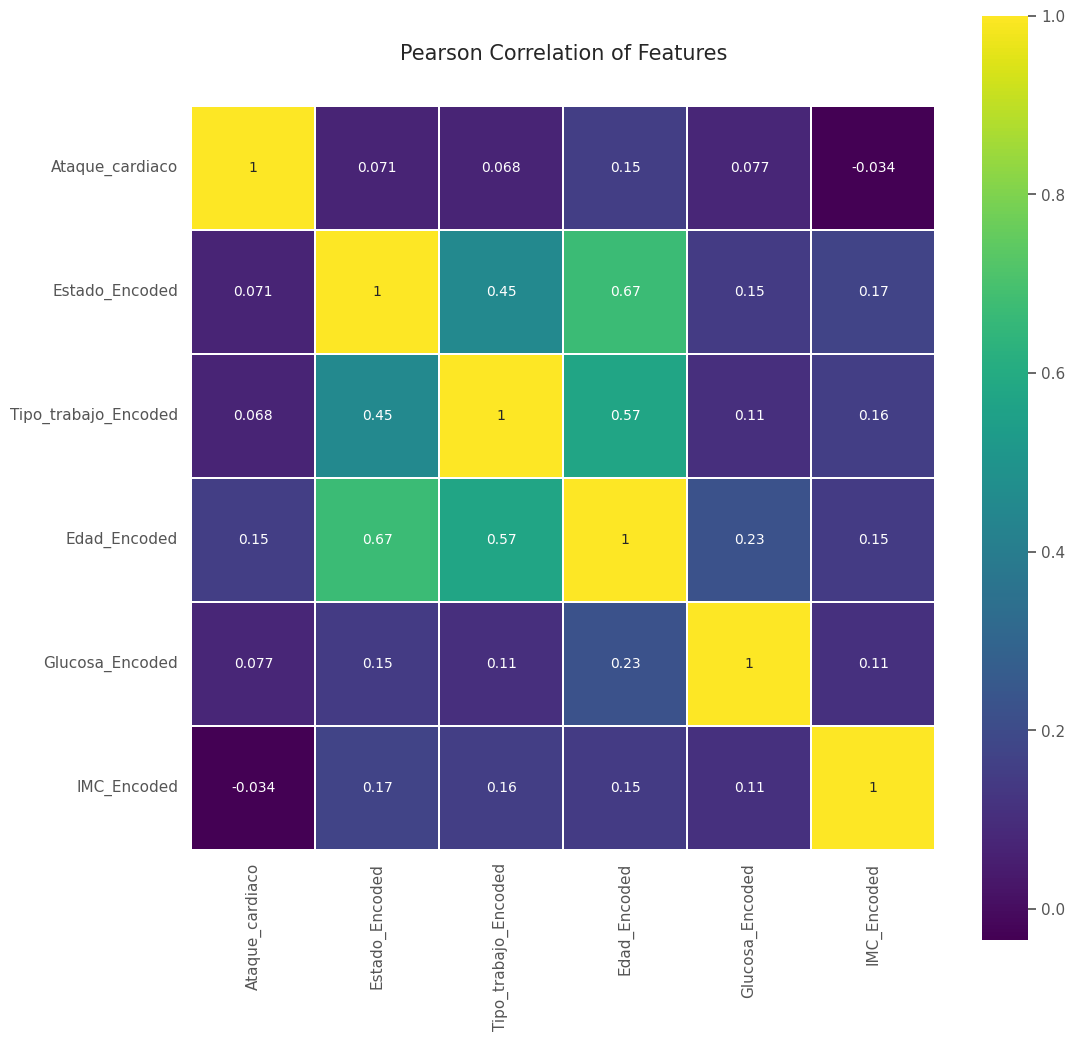

In [103]:
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(df_encoded.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

Segun el algortimo las 3 variables mas criticas son:'Edad', 'Promedio_nivel_glucosa', 'Estado_Encoded'

Comprobemoslo!

In [104]:
df_encoded[['Estado_Encoded', 'Ataque_cardiaco']].groupby(['Estado_Encoded'], as_index=False).agg(['mean', 'count', 'sum'])

Ataque_cardiaco            
                          mean  count  sum
Estado_Encoded                            
0                     0.005345  14966   80
1                     0.025163  27938  703

In [105]:
df_encoded[['Edad_Encoded', 'Ataque_cardiaco']].groupby(['Edad_Encoded'], as_index=False).agg(['mean', 'count', 'sum']).head(20)

Ataque_cardiaco            
                        mean  count  sum
Edad_Encoded                            
0.0                 0.000304   6570    2
1.0                 0.000455   8799    4
2.0                 0.006678  10333   69
3.0                 0.022521  10568  238
4.0                 0.070847   6634  470

In [106]:
df_encoded[['Glucosa_Encoded', 'Ataque_cardiaco']].groupby(['Glucosa_Encoded'], as_index=False).agg(['mean', 'count', 'sum'])

Ataque_cardiaco            
                           mean  count  sum
Glucosa_Encoded                            
0.0                    0.013546  26797  363
1.0                    0.015023  10517  158
2.0                    0.038779   2424   94
3.0                    0.052878   2988  158
4.0                    0.056180    178   10

SE OBSERVA QUE:

Dichas variables discriminan el target (Ataque_cardiaco) ya que tienen una tendencia en su distribucion:

-Estado civil casado (mayor % de Casos Ataque cardiaco)

-Los clientes con edad mayor 67 años represetan mayor %

-Con respecto a la glucosa (los de categoria 3 y 4 representan el mayor %




# MUESTREO: Undersampling


## DESBALANCE DE LA MUESTRA:

In [107]:
df_encoded.groupby('Ataque_cardiaco').size()

Ataque_cardiaco
0    42121
1      783
dtype: int64

Class 0 NO ataque: 42121
Class 1 Ataque Cardiaco: 783
Proporción: 53.79 : 1


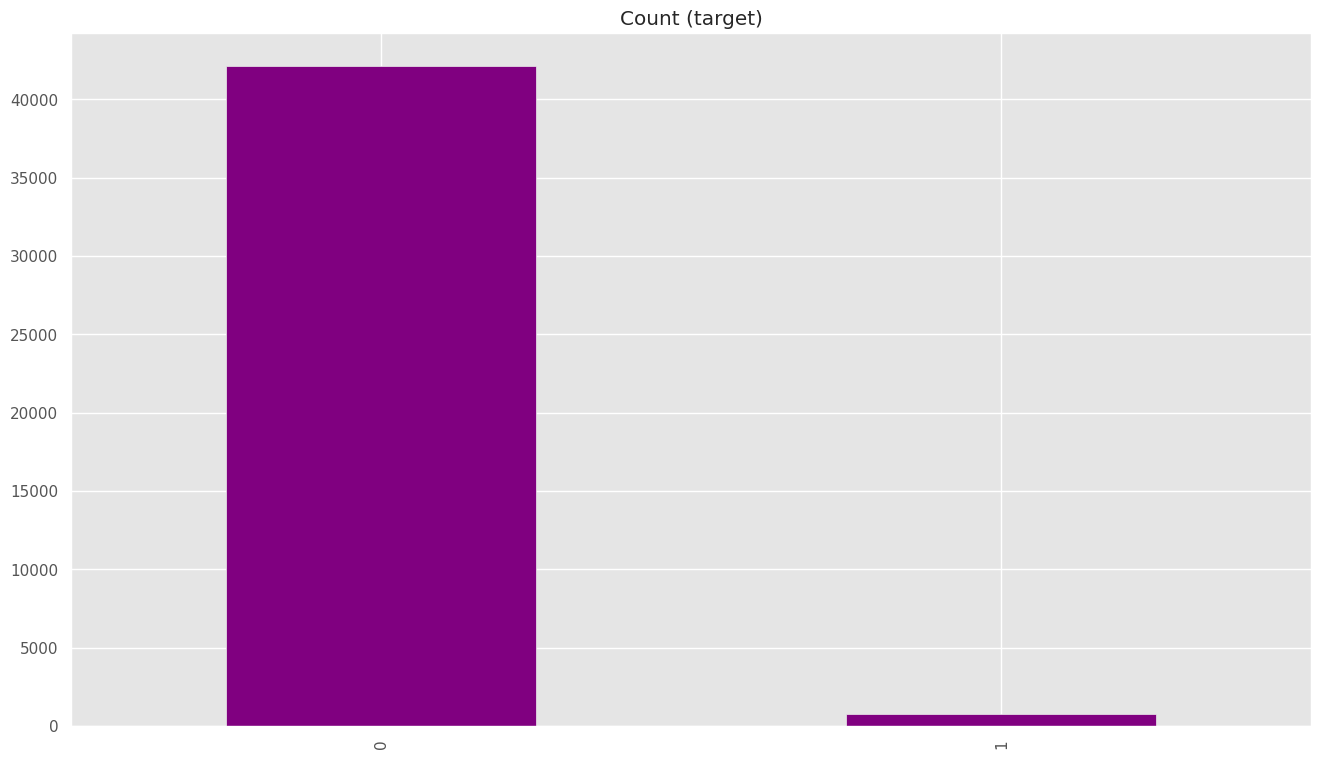

In [108]:
target_count = df_encoded.Ataque_cardiaco.value_counts()
print('Class 0 NO ataque:', target_count[0])
print('Class 1 Ataque Cardiaco:', target_count[1])
print('Proporción:', round(target_count[0] / target_count[1], 2), ': 1')
target_count.plot(kind='bar', color='purple',title='Count (target)');


Se observa un desbalance considerable a simpple vista

##Separando una muestra para verificar resultado de estrategias de muestreo


In [109]:
# Seleccionaremos un 20% de los datos para estudiar el beneficio de las estategias de muestreo

X = df_encoded[['Estado_Encoded',	'Tipo_trabajo_Encoded',	'Edad_Encoded',	'IMC_Encoded',	'Glucosa_Encoded']]
y = df_encoded[['Ataque_cardiaco']]

#np.random.seed(101)
import sklearn.model_selection as model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, train_size=0.8,test_size=0.2, random_state=101)

## Undersampling


In [110]:
# Solo utilizaremos Datos de entrenamiento para la estrategia
df_train = pd.concat([X_train,y_train],axis=1)

In [111]:
df_train.head()

,Estado_Encoded,Tipo_trabajo_Encoded,Edad_Encoded,IMC_Encoded,Glucosa_Encoded,Ataque_cardiaco
1663,1,3,2.0,1.0,1.0,0
41837,1,3,2.0,1.0,0.0,0
11915,1,2,3.0,1.0,0.0,0
6221,1,3,3.0,1.0,1.0,0
40034,1,3,3.0,2.0,0.0,0


In [112]:
df_train.shape

(34323, 6)

In [113]:
#División del traget
count_class_0, count_class_1 = df_train.Ataque_cardiaco.value_counts()

# Divide by class
df_class_0 = df_train[df_train['Ataque_cardiaco'] == 0]
df_class_1 = df_train[df_train['Ataque_cardiaco'] == 1]

In [114]:
count_class_0, len(df_class_0), count_class_1, len(df_class_1)

(33717, 33717, 606, 606)

esos valores representan el 80% del total de la muestra

In [115]:
df_class_0.sample(3)

,Estado_Encoded,Tipo_trabajo_Encoded,Edad_Encoded,IMC_Encoded,Glucosa_Encoded,Ataque_cardiaco
40772,0,3,1.0,2.0,1.0,0
21142,1,3,2.0,1.0,1.0,0
34539,1,3,2.0,2.0,0.0,0


Estrategia de Muestreo under-sampling:
0    606
1    606
Name: Ataque_cardiaco, dtype: int64


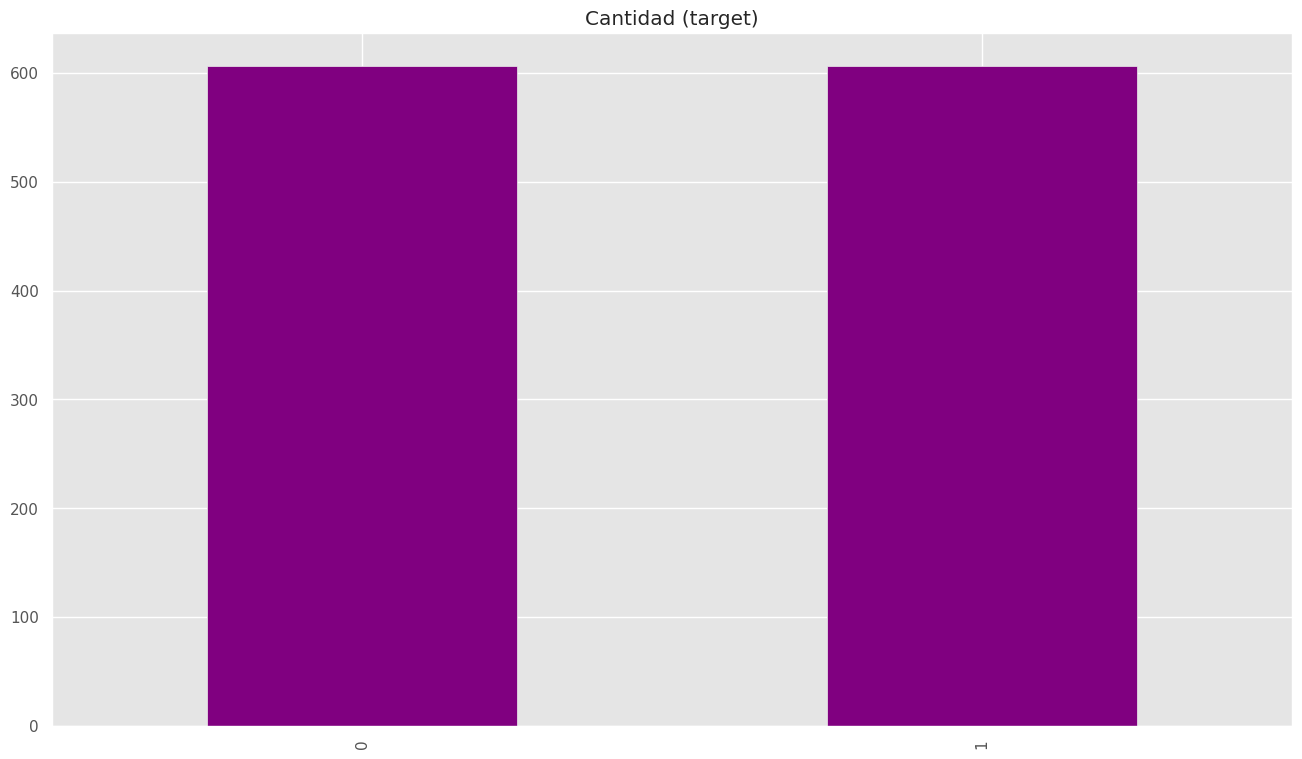

In [116]:
df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Estrategia de Muestreo under-sampling:')
print(df_test_under.Ataque_cardiaco.value_counts())

df_test_under.Ataque_cardiaco.value_counts().plot(kind='bar', color='purple', title='Cantidad (target)');

## OVERSAMPLING

In [117]:
aux = df_class_1.head(2)
aux.sample(4,replace=True)

,Estado_Encoded,Tipo_trabajo_Encoded,Edad_Encoded,IMC_Encoded,Glucosa_Encoded,Ataque_cardiaco
18396,1,4,4.0,2.0,1.0,1
18396,1,4,4.0,2.0,1.0,1
18396,1,4,4.0,2.0,1.0,1
12246,1,4,4.0,2.0,1.0,1


Random over-sampling:
0    33717
1    33717
Name: Ataque_cardiaco, dtype: int64


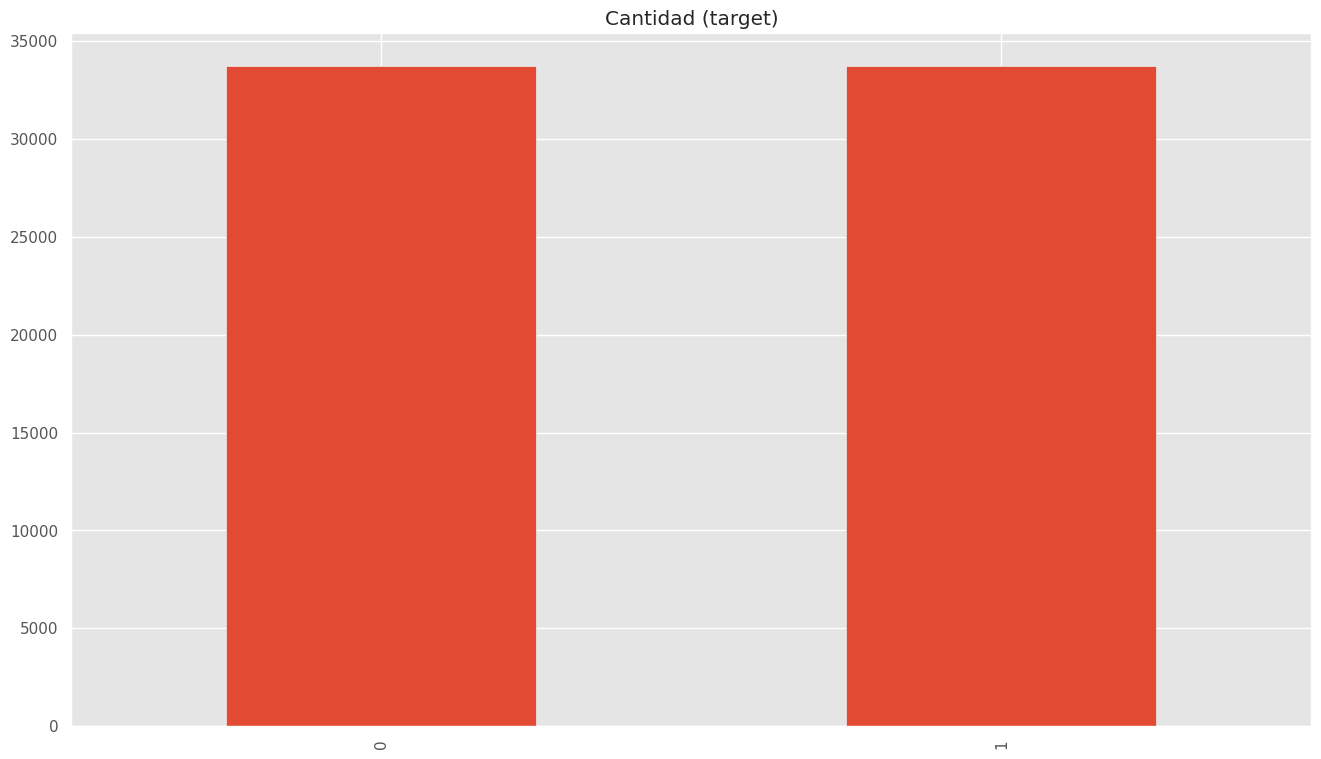

In [118]:
# hay un riesgo de que algunas filas no sean consideradas porque la aletoriedad las ignorara
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_test_over.Ataque_cardiaco.value_counts())

df_test_over.Ataque_cardiaco.value_counts().plot(kind='bar', title='Cantidad (target)');

# MODELAMIENTO y MATRIZ DE CONFUSIÓN: TREECLASSIFIER//UNDERSAMPLING//OVERSAMPLING


## **DATOS ORIGINALES:**

In [119]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, log_loss

model = DecisionTreeClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy DATOS ORIGINALES: %.2f%%" % (accuracy * 100.0))

ll = log_loss(y_test, y_pred)
print("Log Loss: {}".format(ll))

Accuracy DATOS ORIGINALES: 97.94%
Log Loss: 0.7434712329418176


Donde el Log loss representa el logaritmo de la cantidad de errores del modelo: muestra un valor bajo.

AHORA VEAMOS LA MATRIZ DE CONFUSION:
 Para analizar mas afondo como ah trabajado elm modelo con los datos reales.

Matriz de Confusión - DATOS ORIGINALES:
 [[8404    0]
 [ 177    0]]
Métricas de Matriz de Confusión - DATOS ORIGINALES:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      8404
           1       0.00      0.00      0.00       177

    accuracy                           0.98      8581
   macro avg       0.49      0.50      0.49      8581
weighted avg       0.96      0.98      0.97      8581



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-120-8549ff0cef83>:18: UserWarning: FixedFormatter

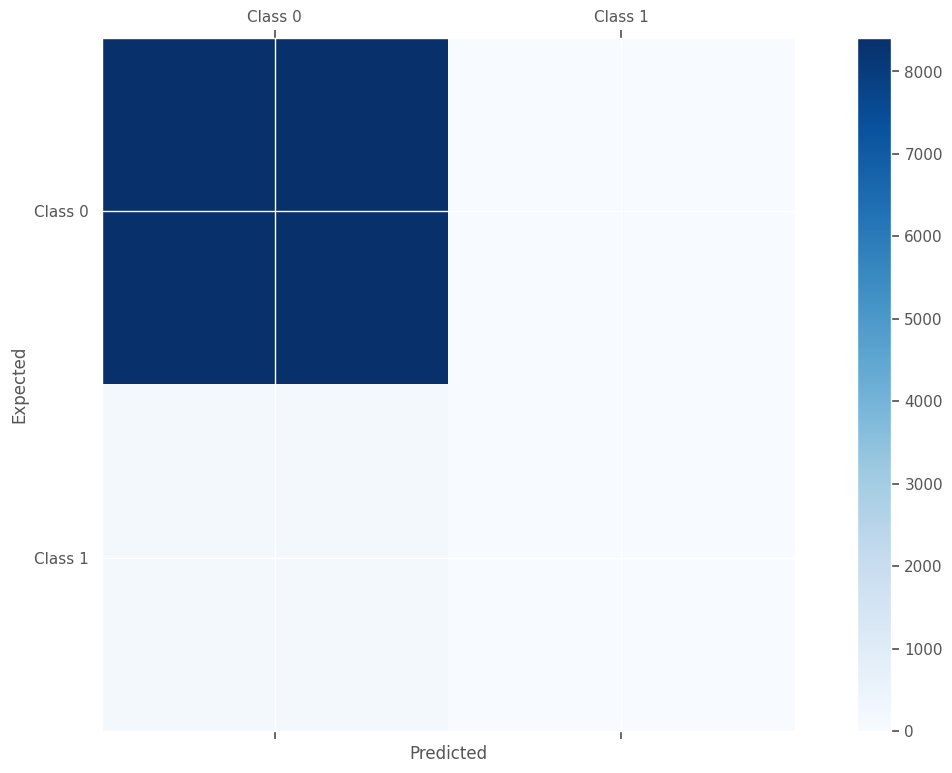

In [120]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt


#--------------------------------------------------------------------
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
#--------------------------------------------------------------------

print('Matriz de Confusión - DATOS ORIGINALES:\n', conf_mat)

print('Métricas de Matriz de Confusión - DATOS ORIGINALES:\n',classification_report(y_test,y_pred))

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

## **UNDERSAMPLING**

In [121]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

model = DecisionTreeClassifier()

X_train_u= df_test_under[['Estado_Encoded',	'Tipo_trabajo_Encoded',	'Edad_Encoded',	'IMC_Encoded',	'Glucosa_Encoded']]
y_train_u = df_test_under[['Ataque_cardiaco']]

model.fit(X_train_u, y_train_u)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy UNDERSAMPLING: %.2f%%" % (accuracy * 100.0))
ll = log_loss(y_test, y_pred)
print("Log Loss: {}".format(ll))

Accuracy UNDERSAMPLING: 73.86%
Log Loss: 9.421502686375687


Matriz de Confusión UNDERSAMPLING:
 [[6201 2203]
 [  40  137]]
Métricas de Matriz de Confusión - UNDERSAMPLING:
               precision    recall  f1-score   support

           0       0.99      0.74      0.85      8404
           1       0.06      0.77      0.11       177

    accuracy                           0.74      8581
   macro avg       0.53      0.76      0.48      8581
weighted avg       0.97      0.74      0.83      8581



<ipython-input-122-8f988630fb46>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
<ipython-input-122-8f988630fb46>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


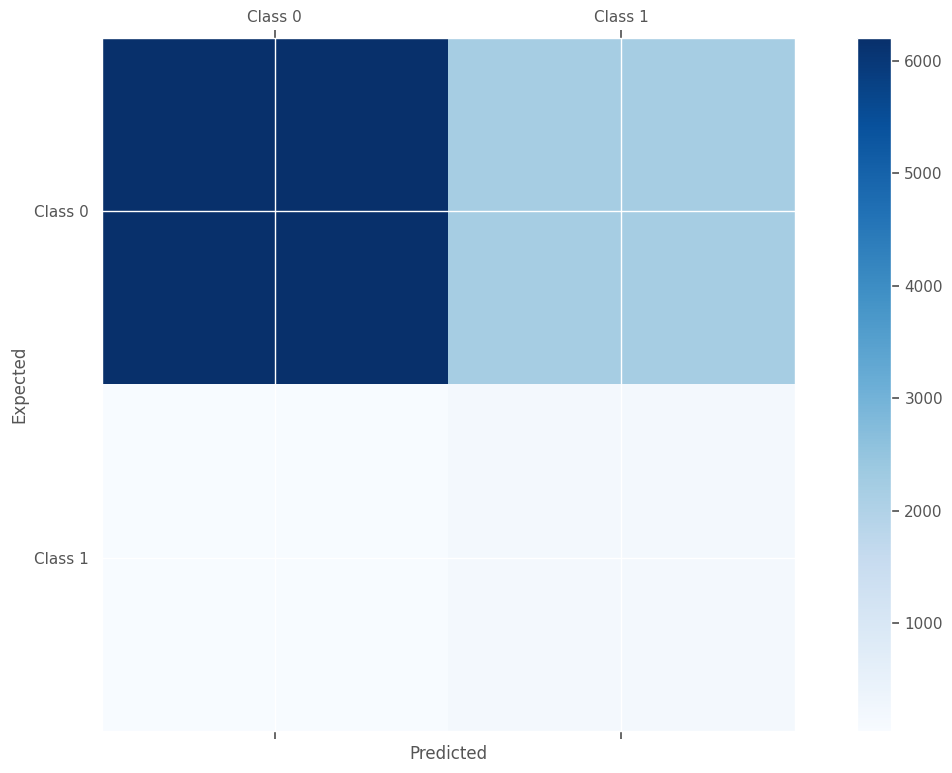

In [122]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

#--------------------------------------------------------------------
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
#--------------------------------------------------------------------

print('Matriz de Confusión UNDERSAMPLING:\n', conf_mat)

print('Métricas de Matriz de Confusión - UNDERSAMPLING:\n',classification_report(y_test,y_pred))

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

## **OVERSAMPLING**

In [123]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

model = DecisionTreeClassifier()

X_train_o= df_test_over[['Estado_Encoded',	'Tipo_trabajo_Encoded',	'Edad_Encoded',	'IMC_Encoded',	'Glucosa_Encoded']]
y_train_o = df_test_over[['Ataque_cardiaco']]

model.fit(X_train_o, y_train_o)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy OVERSAMPLING: %.2f%%" % (accuracy * 100.0))
ll = log_loss(y_test, y_pred)
print("Log Loss: {}".format(ll))

Accuracy OVERSAMPLING: 76.62%
Log Loss: 8.426007306673931


Matriz de Confusión OVERSAMPLING:
 [[6439 1965]
 [  41  136]]
Métricas de Matriz de Confusión - OVERSAMPLING:
               precision    recall  f1-score   support

           0       0.99      0.77      0.87      8404
           1       0.06      0.77      0.12       177

    accuracy                           0.77      8581
   macro avg       0.53      0.77      0.49      8581
weighted avg       0.97      0.77      0.85      8581



<ipython-input-124-f5124b008331>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
<ipython-input-124-f5124b008331>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


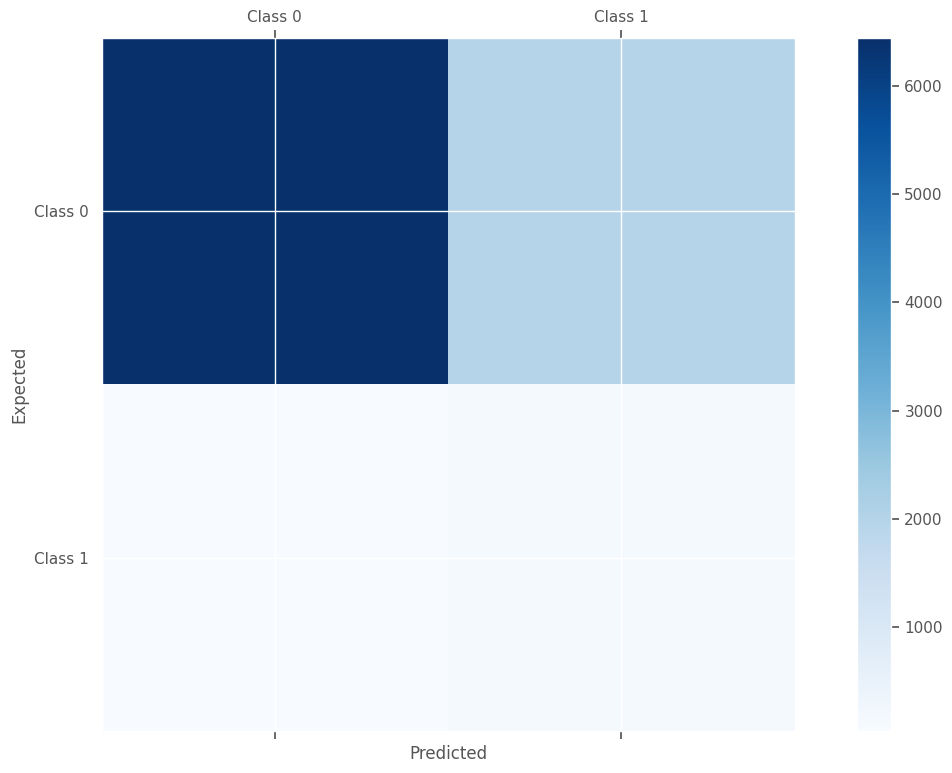

In [124]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt


#--------------------------------------------------------------------
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
#--------------------------------------------------------------------

print('Matriz de Confusión OVERSAMPLING:\n', conf_mat)

print('Métricas de Matriz de Confusión - OVERSAMPLING:\n',classification_report(y_test,y_pred))

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

CREAMOS UN DATA FRAME PARA COMPARAR LOS METODOS DE MUESTREO Y SELECCIONAR EL DE MEJOR PRESICIÓN:

In [125]:
Tabla= pd.DataFrame({'algoritmo': ['Original','Undersampling','Oversampling'],
                     'precisión': [0, 0.06, 0.06],
                     'recall': [0, 0.77, 0.76]})
Tabla

,algoritmo,precisión,recall
0,Original,0.00,0.00
1,Undersampling,0.06,0.77
2,Oversampling,0.06,0.76


# UTILIZANDO OTROS MODELOS:

In [126]:
df_encoded.head()

,Ataque_cardiaco,Estado_Encoded,Tipo_trabajo_Encoded,Edad_Encoded,Glucosa_Encoded,IMC_Encoded
0,0,0,1,0.0,0.0,1.0
1,0,1,3,3.0,0.0,2.0
2,0,0,3,0.0,1.0,1.0
3,0,1,3,4.0,0.0,2.0
4,0,0,0,0.0,2.0,1.0


In [127]:
df_encoded.shape

(42904, 6)

In [128]:
# Seleccionaremos un 35% de los datos para estrudiar el beneficio de las estrategias de muestreo

X = df_encoded[['Estado_Encoded',	'Tipo_trabajo_Encoded',	'Edad_Encoded',	'IMC_Encoded',	'Glucosa_Encoded']]
y = df_encoded[['Ataque_cardiaco']]

#np.random.seed(101)
import sklearn.model_selection as model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, train_size=0.65,test_size=0.35, random_state=101)

In [129]:
#!pip install xgboost

In [130]:
import xgboost as xgb

In [131]:
#Train the XGboost Model for Classification
model1 = xgb.XGBClassifier() # MALA PRACTICA

In [132]:
# parameters tunning
# XGB tunning
model2 = xgb.XGBClassifier(n_estimators=20, max_depth=8, learning_rate=0.1, subsample=0.5)

In [133]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 8.2 MB/s eta 0:00:00


In [134]:
import catboost
from catboost import CatBoostClassifier

In [135]:
#Train the Catboost Model for Classification
model3 = CatBoostClassifier()

In [136]:
from sklearn.ensemble import RandomForestClassifier

In [137]:
#Train RF Model for Classification
model4 = RandomForestClassifier()

In [138]:
# parameters tunning
# RF tunning
model5 = RandomForestClassifier(n_estimators=20, max_depth=8)

In [139]:
model1.fit(X_train_o, y_train_o)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [140]:
model2.fit(X_train_o, y_train_o)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=20, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [141]:
model3.fit(X_train_o, y_train_o)

Learning rate set to 0.062211
0:	learn: 0.6569545	total: 62.5ms	remaining: 1m 2s
1:	learn: 0.6212749	total: 77.5ms	remaining: 38.7s
2:	learn: 0.6002064	total: 91.8ms	remaining: 30.5s
3:	learn: 0.5778950	total: 106ms	remaining: 26.4s
4:	learn: 0.5629648	total: 120ms	remaining: 23.9s
5:	learn: 0.5483209	total: 138ms	remaining: 22.9s
6:	learn: 0.5351077	total: 152ms	remaining: 21.6s
7:	learn: 0.5215985	total: 170ms	remaining: 21s
8:	learn: 0.5128885	total: 200ms	remaining: 22s
9:	learn: 0.5050552	total: 217ms	remaining: 21.5s
10:	learn: 0.4984168	total: 232ms	remaining: 20.8s
11:	learn: 0.4929648	total: 246ms	remaining: 20.2s
12:	learn: 0.4888050	total: 261ms	remaining: 19.8s
13:	learn: 0.4849008	total: 280ms	remaining: 19.7s
14:	learn: 0.4796555	total: 295ms	remaining: 19.4s
15:	learn: 0.4756653	total: 309ms	remaining: 19s
16:	learn: 0.4730688	total: 324ms	remaining: 18.7s
17:	learn: 0.4702299	total: 347ms	remaining: 18.9s
18:	learn: 0.4680981	total: 362ms	remaining: 18.7s
19:	learn: 0.4

In [142]:
model4.fit(X_train_o, y_train_o)

<ipython-input-142-b65123ec7433>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model4.fit(X_train_o, y_train_o)


RandomForestClassifier()

In [143]:
model5.fit(X_train_o, y_train_o)

<ipython-input-143-a743cd9717cc>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model5.fit(X_train_o, y_train_o)


RandomForestClassifier(max_depth=8, n_estimators=20)

In [144]:
import sklearn
sklearn.__version__

'1.2.2'

In [145]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score


X_train_o= df_test_over[['Estado_Encoded',	'Tipo_trabajo_Encoded',	'Edad_Encoded',	'IMC_Encoded',	'Glucosa_Encoded']]
y_train_o = df_test_over[['Ataque_cardiaco']]

model1.fit(X_train_o, y_train_o)
y_pred = model1.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy OVERSAMPLING model1: %.2f%%" % (accuracy * 100.0))
ll = log_loss(y_test, y_pred)
print("Log Loss: {}".format(ll))

Accuracy OVERSAMPLING model1: 75.23%
Log Loss: 8.928706839416382


In [146]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt


#--------------------------------------------------------------------
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
#--------------------------------------------------------------------

print('Matriz de Confusión :\n', conf_mat)

print('Métricas de Matriz de Confusión - Model1:\n',classification_report(y_test,y_pred))


Matriz de Confusión :
 [[11057  3665]
 [   55   240]]
Métricas de Matriz de Confusión - Model1:
               precision    recall  f1-score   support

           0       1.00      0.75      0.86     14722
           1       0.06      0.81      0.11       295

    accuracy                           0.75     15017
   macro avg       0.53      0.78      0.49     15017
weighted avg       0.98      0.75      0.84     15017



In [147]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score


X_train_o= df_test_over[['Estado_Encoded',	'Tipo_trabajo_Encoded',	'Edad_Encoded',	'IMC_Encoded',	'Glucosa_Encoded']]
y_train_o = df_test_over[['Ataque_cardiaco']]

model2.fit(X_train_o, y_train_o)
y_pred = model2.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy OVERSAMPLING model2: %.2f%%" % (accuracy * 100.0))
ll = log_loss(y_test, y_pred)
print("Log Loss: {}".format(ll))

Accuracy OVERSAMPLING model2: 74.24%
Log Loss: 9.28393496098456


In [148]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt


#--------------------------------------------------------------------
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
#--------------------------------------------------------------------

print('Matriz de Confusión :\n', conf_mat)

print('Métricas de Matriz de Confusión - Model2:\n',classification_report(y_test,y_pred))

Matriz de Confusión :
 [[10904  3818]
 [   50   245]]
Métricas de Matriz de Confusión - Model2:
               precision    recall  f1-score   support

           0       1.00      0.74      0.85     14722
           1       0.06      0.83      0.11       295

    accuracy                           0.74     15017
   macro avg       0.53      0.79      0.48     15017
weighted avg       0.98      0.74      0.83     15017



In [149]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score


X_train_o= df_test_over[['Estado_Encoded',	'Tipo_trabajo_Encoded',	'Edad_Encoded',	'IMC_Encoded',	'Glucosa_Encoded']]
y_train_o = df_test_over[['Ataque_cardiaco']]

model3.fit(X_train_o, y_train_o)
y_pred = model3.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy OVERSAMPLING model3: %.2f%%" % (accuracy * 100.0))
ll = log_loss(y_test, y_pred)
print("Log Loss: {}".format(ll))

Learning rate set to 0.062211
0:	learn: 0.6569545	total: 17ms	remaining: 17s
1:	learn: 0.6212749	total: 35.5ms	remaining: 17.7s
2:	learn: 0.6002064	total: 51.4ms	remaining: 17.1s
3:	learn: 0.5778950	total: 65.8ms	remaining: 16.4s
4:	learn: 0.5629648	total: 97.2ms	remaining: 19.3s
5:	learn: 0.5483209	total: 117ms	remaining: 19.3s
6:	learn: 0.5351077	total: 135ms	remaining: 19.2s
7:	learn: 0.5215985	total: 151ms	remaining: 18.7s
8:	learn: 0.5128885	total: 167ms	remaining: 18.4s
9:	learn: 0.5050552	total: 182ms	remaining: 18s
10:	learn: 0.4984168	total: 201ms	remaining: 18s
11:	learn: 0.4929648	total: 219ms	remaining: 18.1s
12:	learn: 0.4888050	total: 234ms	remaining: 17.8s
13:	learn: 0.4849008	total: 249ms	remaining: 17.5s
14:	learn: 0.4796555	total: 264ms	remaining: 17.3s
15:	learn: 0.4756653	total: 280ms	remaining: 17.2s
16:	learn: 0.4730688	total: 299ms	remaining: 17.3s
17:	learn: 0.4702299	total: 314ms	remaining: 17.1s
18:	learn: 0.4680981	total: 336ms	remaining: 17.4s
19:	learn: 0.4

In [150]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt


#--------------------------------------------------------------------
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
#--------------------------------------------------------------------

print('Matriz de Confusión :\n', conf_mat)

print('Métricas de Matriz de Confusión - model3:\n',classification_report(y_test,y_pred))

Matriz de Confusión :
 [[11326  3396]
 [   66   229]]
Métricas de Matriz de Confusión - model3:
               precision    recall  f1-score   support

           0       0.99      0.77      0.87     14722
           1       0.06      0.78      0.12       295

    accuracy                           0.77     15017
   macro avg       0.53      0.77      0.49     15017
weighted avg       0.98      0.77      0.85     15017



In [151]:
y_pred

array([1, 0, 1, ..., 1, 0, 0])

In [152]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score


X_train_o= df_test_over[['Estado_Encoded',	'Tipo_trabajo_Encoded',	'Edad_Encoded',	'IMC_Encoded',	'Glucosa_Encoded']]
y_train_o = df_test_over[['Ataque_cardiaco']]

model4.fit(X_train_o, y_train_o)
y_pred = model4.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy OVERSAMPLING model4: %.2f%%" % (accuracy * 100.0))
ll = log_loss(y_test, y_pred)
print("Log Loss: {}".format(ll))

<ipython-input-152-852fcccf3489>:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model4.fit(X_train_o, y_train_o)


Accuracy OVERSAMPLING model4: 76.95%
Log Loss: 8.309457816682663


In [153]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt


#--------------------------------------------------------------------
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
#--------------------------------------------------------------------

print('Matriz de Confusión :\n', conf_mat)

print('Métricas de Matriz de Confusión - model4:\n',classification_report(y_test,y_pred))

Matriz de Confusión :
 [[11326  3396]
 [   66   229]]
Métricas de Matriz de Confusión - model4:
               precision    recall  f1-score   support

           0       0.99      0.77      0.87     14722
           1       0.06      0.78      0.12       295

    accuracy                           0.77     15017
   macro avg       0.53      0.77      0.49     15017
weighted avg       0.98      0.77      0.85     15017



In [154]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score


X_train_o= df_test_over[['Estado_Encoded',	'Tipo_trabajo_Encoded',	'Edad_Encoded',	'IMC_Encoded',	'Glucosa_Encoded']]
y_train_o = df_test_over[['Ataque_cardiaco']]

model5.fit(X_train_o, y_train_o)
y_pred = model5.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy OVERSAMPLING model5: %.2f%%" % (accuracy * 100.0))
ll = log_loss(y_test, y_pred)
print("Log Loss: {}".format(ll))

<ipython-input-154-1c6278ec367c>:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model5.fit(X_train_o, y_train_o)


Accuracy OVERSAMPLING model5: 77.36%
Log Loss: 8.160646036025724


In [155]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt


#--------------------------------------------------------------------
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
#--------------------------------------------------------------------

print('Matriz de Confusión :\n', conf_mat)

print('Métricas de Matriz de Confusión - model5:\n',classification_report(y_test,y_pred))

Matriz de Confusión :
 [[11386  3336]
 [   64   231]]
Métricas de Matriz de Confusión - model5:
               precision    recall  f1-score   support

           0       0.99      0.77      0.87     14722
           1       0.06      0.78      0.12       295

    accuracy                           0.77     15017
   macro avg       0.53      0.78      0.49     15017
weighted avg       0.98      0.77      0.86     15017



In [156]:
Tabla_DataOriginal=pd.DataFrame({'algorithm' : ['XGBoost','XGBoost Tuneado','Catboost','RF','RF Tuneado','Arbol de Decision'],
                   'precision' : [0, 0, 0,0,0,0],
                   'recall' : [0, 0, 0,0,0,0,]})
Tabla_DataOriginal

,algorithm,precision,recall
0,XGBoost,0,0
1,XGBoost Tuneado,0,0
2,Catboost,0,0
3,RF,0,0
4,RF Tuneado,0,0
5,Arbol de Decision,0,0


In [157]:
Tabla_OverSampling=pd.DataFrame({'algorithm' : ['XGBoost','XGBoost Tuneado','Catboost','RF','RF Tuneado','Arbol de Decision_Data original','Arbol de Decision_Overs'],
                   'precision' : [0.06, 0.06, 0.06,0.06,0.06,0, 0.06],
                   'recall' : [0.78, 0.77, 0.77,0.77,0.78,0,0.76]})
Tabla_OverSampling

,algorithm,precision,recall
0,XGBoost,0.06,0.78
1,XGBoost Tuneado,0.06,0.77
2,Catboost,0.06,0.77
3,RF,0.06,0.77
4,RF Tuneado,0.06,0.78
5,Arbol de Decision_Data original,0.00,0.00
6,Arbol de Decision_Overs,0.06,0.76


Luego de realiza la matriz de confusion para los diferentes tipos de modelos, se observa que con la data original se obtienen valores 0.

Por lo que tenemos que aplicar el oversampling a cada modelo para que nos de valores mas razonable.

La Tabla_DataOriginal: representa los resultados sin muestreo

La Tabla_Oversampling: Muestra los resultados para los diferentes modelos utilizando el oversampling como tecnica de muestreo.





# JUSTIFICACION DEL MODELO Y METRICA

El modelo que mayor precision y recall representa es el XGBoost:

segun su matriz de confusion:

-el modelo toma como 1(Ataque cardiaco) a 3427 casos de los cuales solo 220 son correctos lo que indica que el modelo no tiene mucha precision esto se puede deber al metodo de muestreo utilizado por lo que se recomienda utilizar alguna otra tecnica.

-En el caso del recall (de los 282 casos reales) el algoritmo detecta 220 casos es decir el 78%

EN CONCLUSION:

EL ALGORITMO SELECCIONADO: mostrará un rango de clase 2 (es decir de SI ataque cardiaco) mayor al real. Dentro de ese rango se encontrara un % considerable de los valores reales)

Considerando esto el algoritmo o modelo sera fiable pero reducira el numero de clientes para la agencia de seguros.

El objetivo es utilizar otras variables de las disponibles para aumentar la precision( QUE ES LA METRICA A PRIORIZAR PARA ESTE CASO), y con ello hacer mas fiable y eficiente el algoritmo.